# Solution Planning - IOT


### 1.0 Input
    1. Problema de Negócio:
        - Classificar quais pedidos de crédito serão inadimplentes e quais serão honrados.
    2. Conjunto de Dados:
        - Clientes que solicitaram crédito e as suas features nas colunas. A granularidade dos dados é 1 cliente para cada linha do dataset.
        
### 2.0 Output
    1. Uma nova coluna no dataset com a classificação de inadimplência do cliente.
    2. Construção de uma API para fazer o deploy do modelo em produção.
    3. A nova coluna será gerada ao clicar em um botão dentro da planilha do Excel, que irá selecionar o dataset, transformá-lo em um arquivo json e fazer uma request na API, a API irá devolver a classificação para o conjunto de dados enviado, e essa classificação irá compor a nova coluna.
    
### 3.0 Tasks
    1. Entendimento do problema de negócio.
    2. Descrição do dados.
    3. Construir o mindmap de hipóteses.
    4. Criar as hipóteses e realizar o feature engineering.
    5. Responder as hipóteses de negócio e realizar a EDA.
    6. Prepração dos dados.
    7. Seleção de features.
    8. Aplicação dos modelos de ML.
    9. Hyperparameter fine tuning.
    10. Tradução e interpretação do erro para negócios.
    11. Construir a classe credit.
    12. Construir a API.
    13. Subir o modelo e a API na cloud.
    14. Construir o script do Excel para fazer a request na API e retornar a previsão como uma nova coluna da tabela.

# 0.0 IMPORTS

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import random            as rd
import scikitplot        as skplt
import matplotlib.pyplot as plt

import locale
import pickle
import requests

from sklearn  import metrics         as m
from sklearn  import model_selection as ms
from imblearn import over_sampling   as overs
from imblearn import combine         as c

from IPython.core.display    import HTML
from boruta                  import BorutaPy
from IPython.display         import Image
from sklearn.model_selection import cross_validate
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor
from sklearn.tree            import DecisionTreeClassifier
from xgboost                 import XGBClassifier

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:70% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv( '../data/treino.csv', low_memory=True )

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Columns Description

● idade: A idade do cliente.

● numero_de_dependentes: O número de pessoas dependentes do cliente.

● salario_mensal: Salário mensal do cliente.

● numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o cliente possui em aberto.

● numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais de 90 dias em atraso.

● util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc.

● vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo.
● razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio

● numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.

● numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.

### 1.1.1 Raw Data Head

In [5]:
df1.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 1.2 Data Dimensions

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Cols: {df1.shape[1]}' )

Number of Rows: 110000
Number of Cols: 11


## 1.3 Data Types

In [7]:
df1.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

## 1.4 Check NA's

In [8]:
df1.isna().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [9]:
na_salario = df1['salario_mensal'].isna().sum()
na_dependentes = df1['numero_de_dependentes'].isna().sum()

In [10]:
print( f'% of NAs i8n salario_mensal: { 100*(na_salario / len( df1 )):.2f}'  )
print( f'% of NAs in numero_de_dependentes: { 100*(na_dependentes / len( df1 )):.2f}'  )

% of NAs i8n salario_mensal: 19.78
% of NAs in numero_de_dependentes: 2.62


## 1.5 Fill NA's

### 1.5.1 Salário Mensal

<Axes: xlabel='salario_mensal', ylabel='Count'>

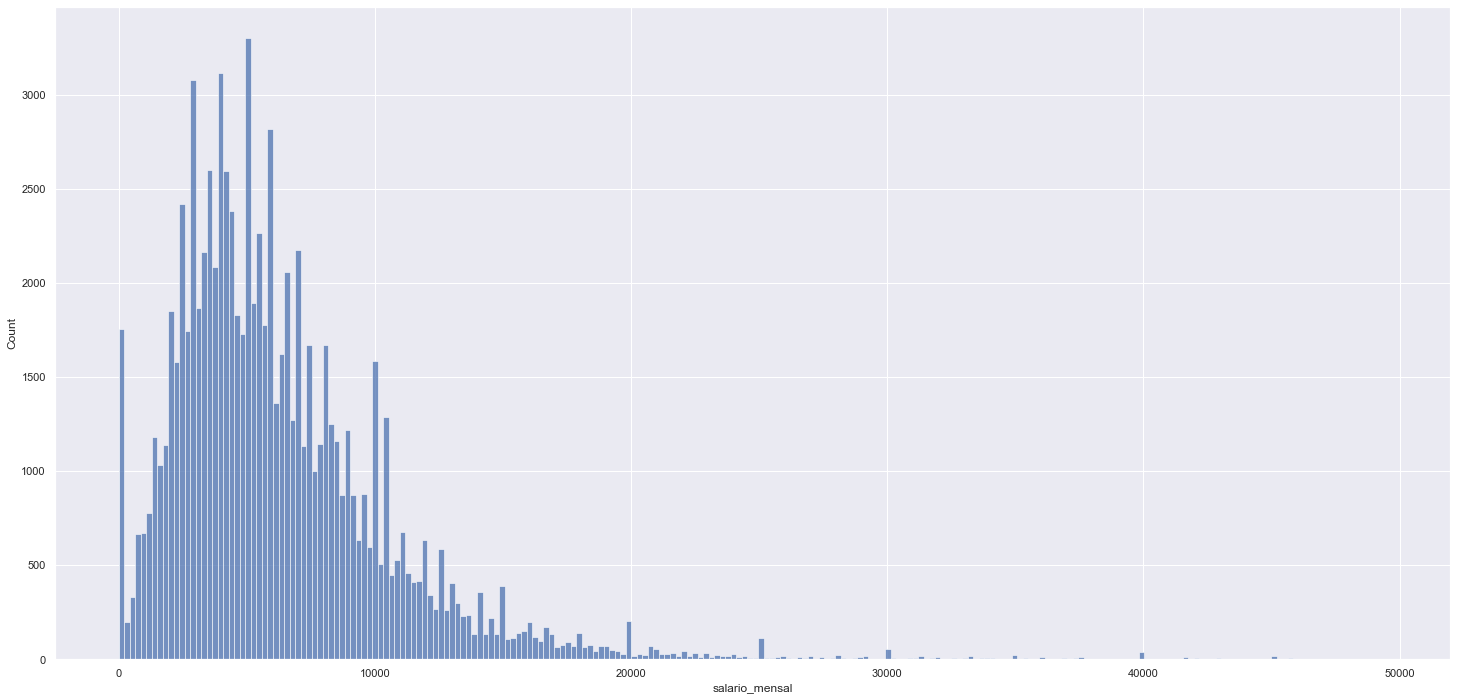

In [11]:
sns.histplot( df1.loc[df1['salario_mensal'] < 50000, 'salario_mensal' ] )

<Axes: >

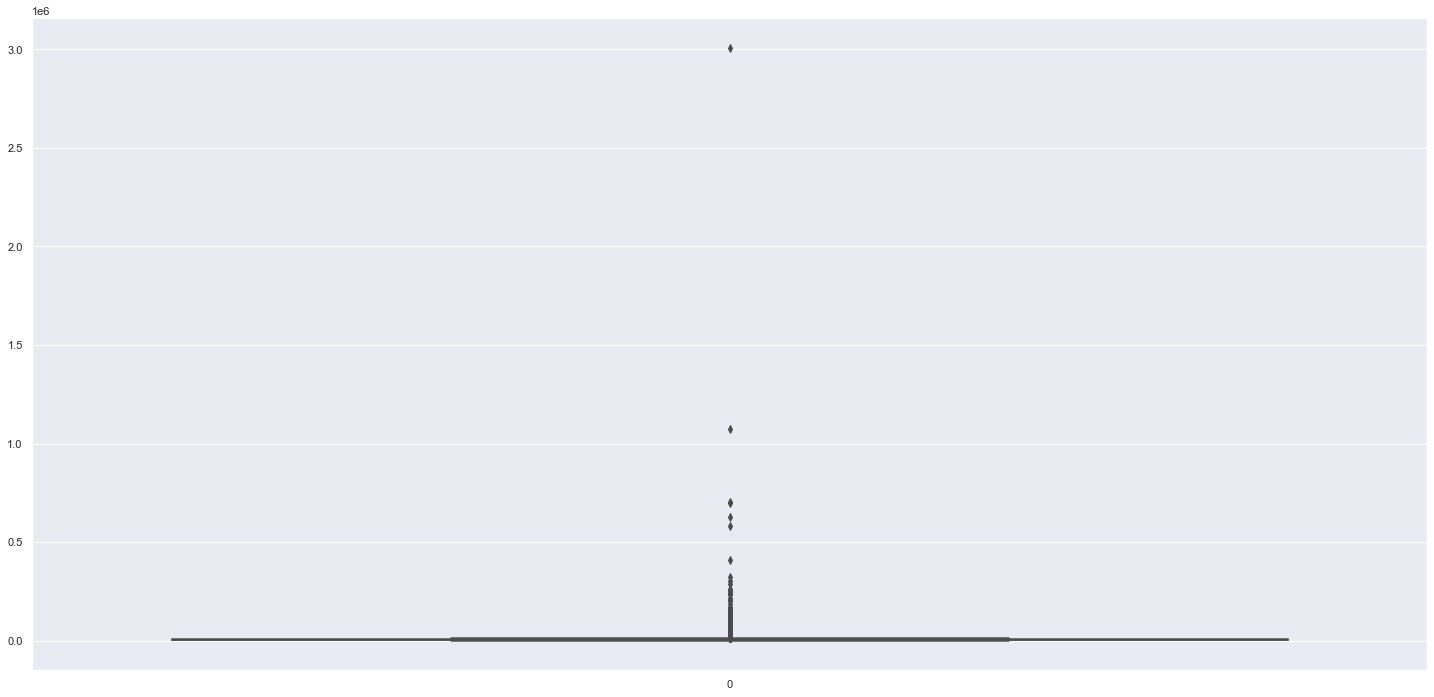

In [12]:
sns.boxplot( df1['salario_mensal'] )

In [13]:
df1['salario_mensal'].fillna( df1.loc[df1['salario_mensal'] < 300000, 'salario_mensal'].mean(), inplace=True )

In [14]:
df1.isna().sum()

inadimplente                                0
util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                              0
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    2878
dtype: int64

### 1.5.2 Número de Dependentes

In [15]:
df_raw['numero_de_dependentes'].mean()

0.757482123186647

In [16]:
df_raw['numero_de_dependentes'].median()

0.0

<Axes: xlabel='numero_de_dependentes', ylabel='Count'>

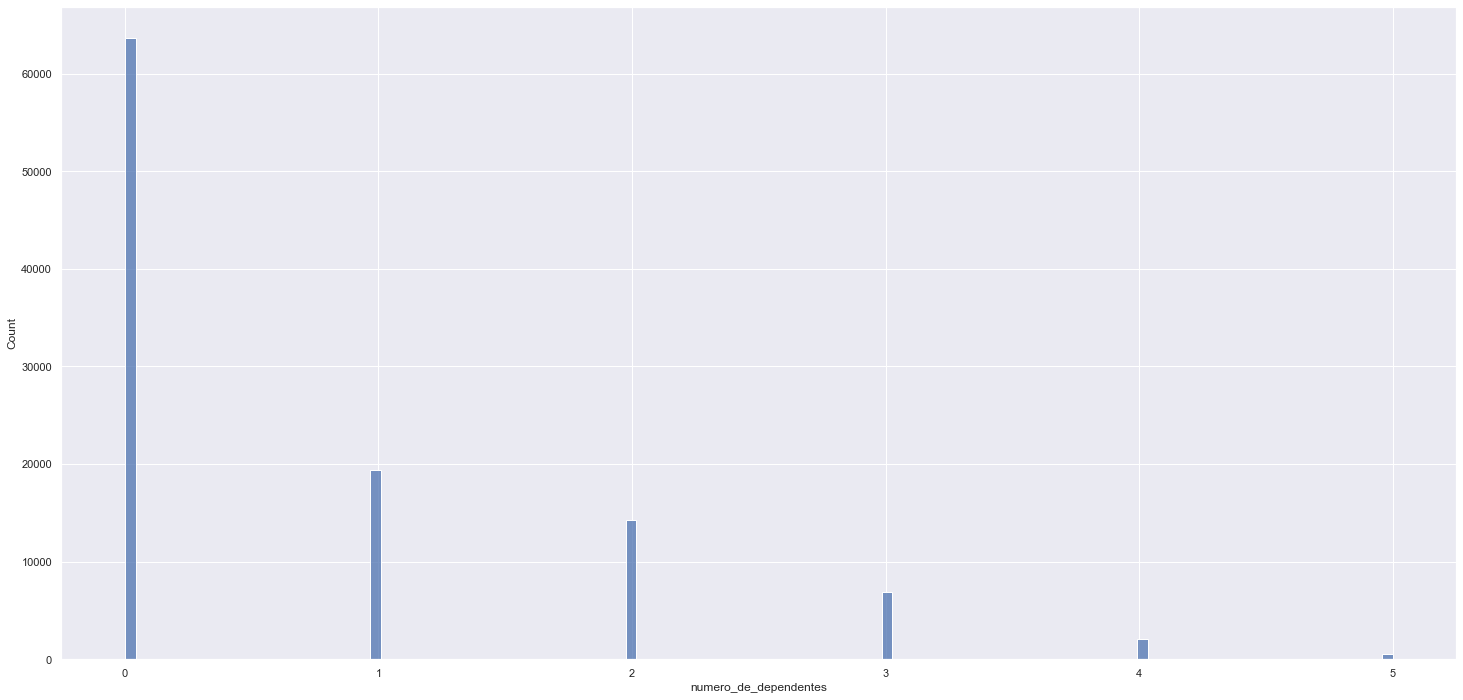

In [17]:
sns.histplot( df_raw.loc[df_raw['numero_de_dependentes'] <= 5, 'numero_de_dependentes'] )

In [18]:
df1['numero_de_dependentes'].fillna( df1['numero_de_dependentes'].median(), inplace=True )

In [19]:
df1.isna().sum()

inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

### 1.5.3 Idade

<Axes: xlabel='idade', ylabel='Count'>

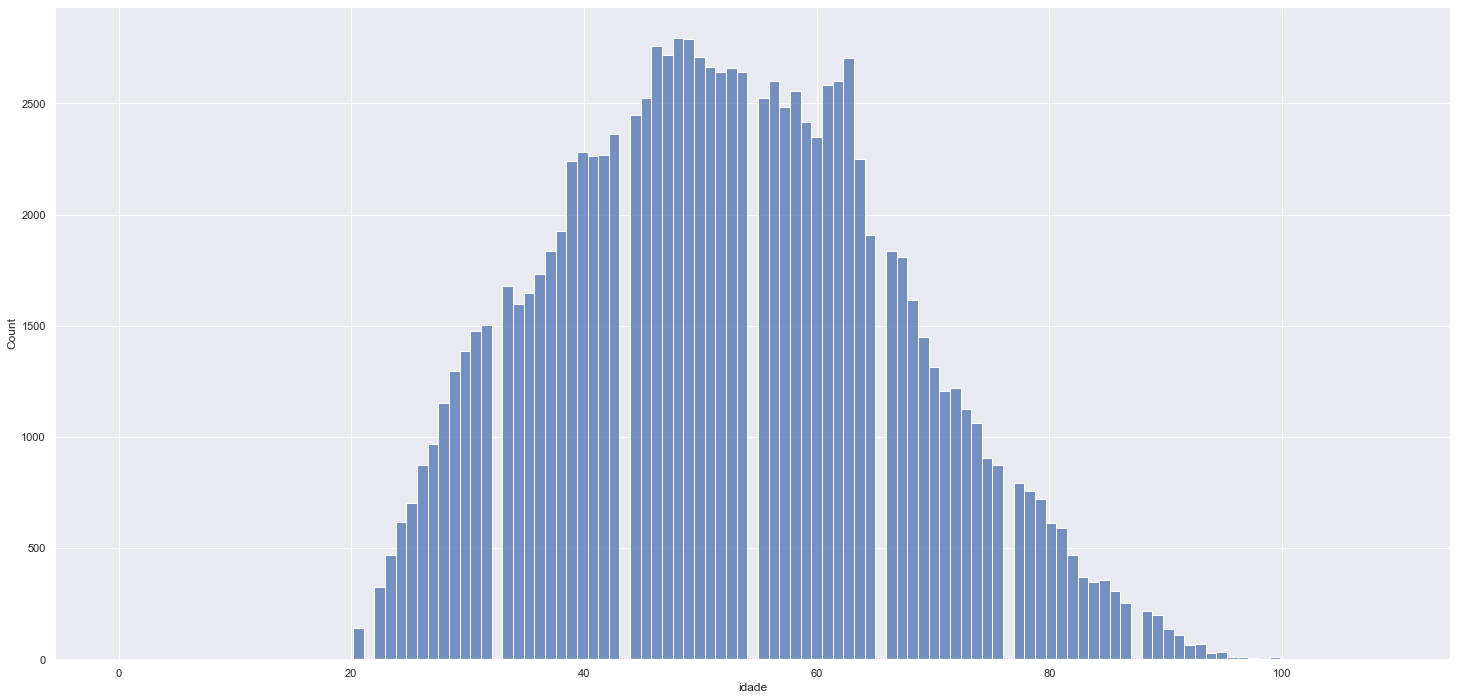

In [20]:
sns.histplot( df1['idade'] )

In [21]:
df1['idade'].min()

0

In [22]:
df1['idade'] = df1['idade'].replace( 0, round( df1['idade'].mean() ) )

In [23]:
df1['idade'].min()

21

## 1.6 Change Types

In [24]:
df1['numero_de_dependentes'] = df1['numero_de_dependentes'].astype( int )

## 1.7 Descriptive Statistics

In [25]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T

# Dispersion - Std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
statistics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
statistics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [26]:
statistics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,inadimplente,0.0,1.0,1.0,0.066645,0.000000,0.249407,3.475127,10.076691
1,util_linhas_inseguras,0.0,50708.0,50708.0,5.929979,0.155936,252.300818,109.363239,17653.519208
2,idade,21.0,109.0,88.0,52.256109,52.000000,14.767333,0.188021,-0.498130
3,vezes_passou_de_30_59_dias,0.0,98.0,98.0,0.424055,0.000000,4.240761,22.358208,510.931290
4,razao_debito,0.0,329664.0,329664.0,354.823589,0.366682,2074.130993,92.913075,13094.884586
5,salario_mensal,0.0,3008750.0,3008750.0,6620.208803,6550.463096,11987.060926,157.099513,36692.450996
6,numero_linhas_crdto_aberto,0.0,58.0,58.0,8.445573,8.000000,5.139003,1.198544,3.009576
7,numero_vezes_passou_90_dias,0.0,98.0,98.0,0.269955,0.000000,4.217307,22.837191,525.789190
8,numero_emprestimos_imobiliarios,0.0,54.0,54.0,1.019891,1.000000,1.135984,3.790920,73.539832
9,numero_de_vezes_que_passou_60_89_dias,0.0,98.0,98.0,0.243891,0.000000,4.204118,23.062550,533.011147


# 2.0 FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mindmap Hypotheses

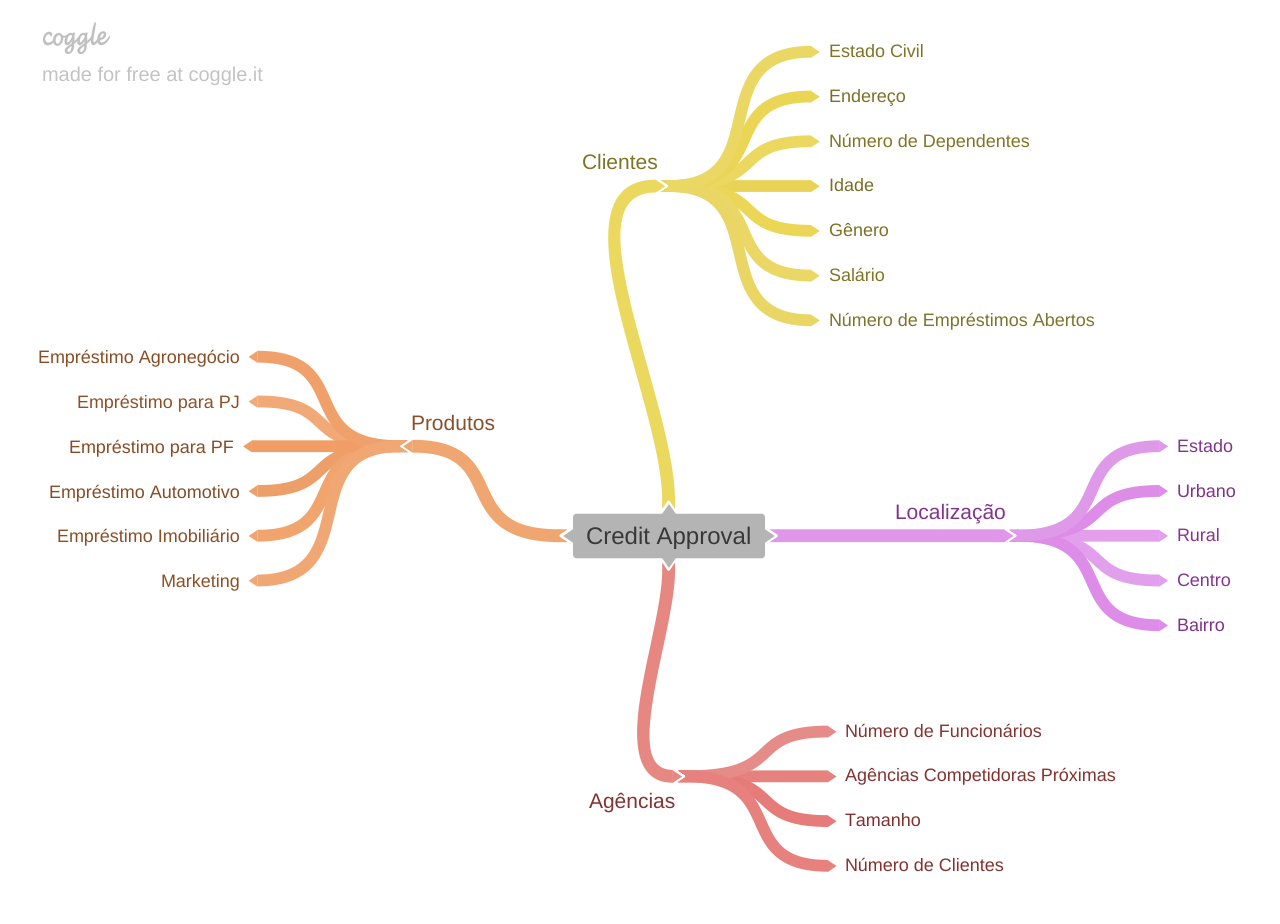

In [28]:
Image( '../img/Credit_Approval.png' )

## 2.2 Hypotheses Creating

### 2.2.1 Client Hypotheses

**1.** Clientes do estado civil casado, são 30% menos inadimplentes do que clientes do estado civil solteiro.

**2.** Clientes com razão débito maior, são mais inadimplentes do que cliente com razão débito menor.

**3.** Clientes com número de dependentes maiores, são mais inadimplentes do que clientes com números menores.

**4.** Clientes mais velhos são menos inadimplentes do que clientes mais novos.

**5.** Clientes com salários maiores são menos inadimplentes do que clientes com salários menores.

**6.** Clientes com maiores números de empréstimos abertos, são mais inadimplentes do que clientes com menos empréstimos abertos.

### 2.2.2 Product Hypotheses

**1.** Os clientes PJ são 30% mais inadimplentes do que os clientes PF.

**2.** Os empréstimos imobiliários correspondem a mais de 40% de todo o crédito concedido.

**3.** Os empréstimos automotivos são os que mais possuem inadimplência.

**4.** Propagandas com taxas de juros atrativas aumentam os pedidos de crédito.

### 2.2.3 Agency Hypotheses

**1.** Agências com maior números de funcionários captam mais pedidos de crédito.

**2.** Agências com competidores próximos tendem a ter menor solicitações de crédito.

**3.** Agências com maiores números de clientes possuem maiior inadimplência.

### 2.2.4 Lozalization Hypotheses

**1.** O estado de São Paulo é o que tem a maior quantidade de pedidos de crédito.

**2.** Clientes de centros urbanos solicitam empréstimos 50% maiores do que cliente de área rural.

**3.** Agências de bairro possuem uma base de clientes mais velhos.

**4.** Agências de centro possuem 25% mais inadimplência do que agências de bairro.

### 2.2.5 Hypotheses Final List

**1.** Clientes com razão débito maior, são mais inadimplentes do que cliente com razão débito menor.

**2.** Clientes com número de dependentes maiores, são mais inadimplentes do que clientes com números menores.

**3.** Clientes mais velhos são menos inadimplentes do que clientes mais novos.

**4.** Clientes com salários maiores são menos inadimplentes do que clientes com salários menores.

**5.** Clientes com maiores números de empréstimos abertos, são mais inadimplentes do que clientes com menos empréstimos abertos.

## 2.2 Feature Engineering

In [29]:
# Salário por denpendentes
df2['salario_por_dependentes'] = df2[['salario_mensal', 'numero_de_dependentes']].apply( lambda x: x['salario_mensal'] if x['numero_de_dependentes'] == 0 else x['salario_mensal'] / x['numero_de_dependentes'], axis=1 )

# Salário por número de empréstimos abertos
df2['salario_por_emprestimos'] = df2[['salario_mensal', 'numero_linhas_crdto_aberto']].apply( lambda x: x['salario_mensal'] if x['numero_linhas_crdto_aberto'] == 0 else x['salario_mensal'] / x['numero_linhas_crdto_aberto'], axis=1 )

# Soma do número de vezesque passou de 30, 60 e 90 dias
df2['soma_passou'] = df2['vezes_passou_de_30_59_dias'] + df2['numero_vezes_passou_90_dias'] + df2['numero_de_vezes_que_passou_60_89_dias']

# Razão débito vezes o salário
df2['debito_x_salario'] = df2['razao_debito'] * df2['salario_mensal']

# util linhas inseguras vezes numero de linhas de crédito aberto
df2['linhas_credito_inseguras'] = df2['util_linhas_inseguras'] * df2['numero_linhas_crdto_aberto']

# Idade vezes o salário
df2['idade_x_salario'] = df2['idade'] * df2['salario_mensal']

In [30]:
df2.loc[df2['vezes_passou_de_30_59_dias'] > 50].head( 20 )

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,salario_por_dependentes,salario_por_emprestimos,soma_passou,debito_x_salario,linhas_credito_inseguras,idade_x_salario
1733,1,1.0,27,98,0.000000,2700.000000,0,98,0,98,0,2700.000000,2700.000000,294,0.000000,0.0,72900.000000
2286,0,1.0,22,98,0.000000,6550.463096,0,98,0,98,0,6550.463096,6550.463096,294,0.000000,0.0,144110.188104
3884,0,1.0,38,98,12.000000,6550.463096,0,98,0,98,0,6550.463096,6550.463096,294,78605.557147,0.0,248917.597633
4417,0,1.0,21,98,0.000000,0.000000,0,98,0,98,0,0.000000,0.000000,294,0.000000,0.0,0.000000
4705,0,1.0,21,98,0.000000,2000.000000,0,98,0,98,0,2000.000000,2000.000000,294,0.000000,0.0,42000.000000
5073,0,1.0,33,98,0.000000,1500.000000,0,98,0,98,0,1500.000000,1500.000000,294,0.000000,0.0,49500.000000
6280,1,1.0,51,98,0.000000,7500.000000,0,98,0,98,0,7500.000000,7500.000000,294,0.000000,0.0,382500.000000
7032,1,1.0,29,98,0.000000,1647.000000,0,98,0,98,0,1647.000000,1647.000000,294,0.000000,0.0,47763.000000
7117,1,1.0,25,98,21.000000,6550.463096,0,98,0,98,0,6550.463096,6550.463096,294,137559.725008,0.0,163761.577390
7687,1,1.0,21,98,0.000000,6550.463096,0,98,0,98,0,6550.463096,6550.463096,294,0.000000,0.0,137559.725008


# 3.0 DATA FILTERING

In [31]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [32]:
# Removing outliers
df3 = df3.loc[ df3['salario_mensal'] < 300000, : ]
df3 = df3.loc[ df3['vezes_passou_de_30_59_dias'] < 50, : ]

## 3.2 Filtering Cols

In [33]:
# High Correlation Variables
df3 = df3.drop( columns=['vezes_passou_de_30_59_dias', 'numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias', 'linhas_credito_inseguras'] )

# 4.0 EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable Distribution

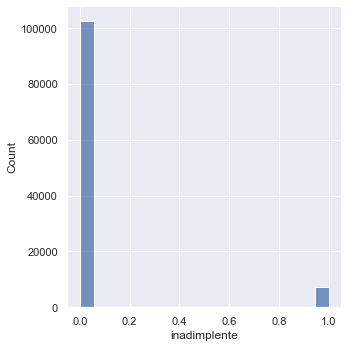

In [35]:
sns.displot( df4['inadimplente'] );

### 4.1.2 Numerical Variable Distribution

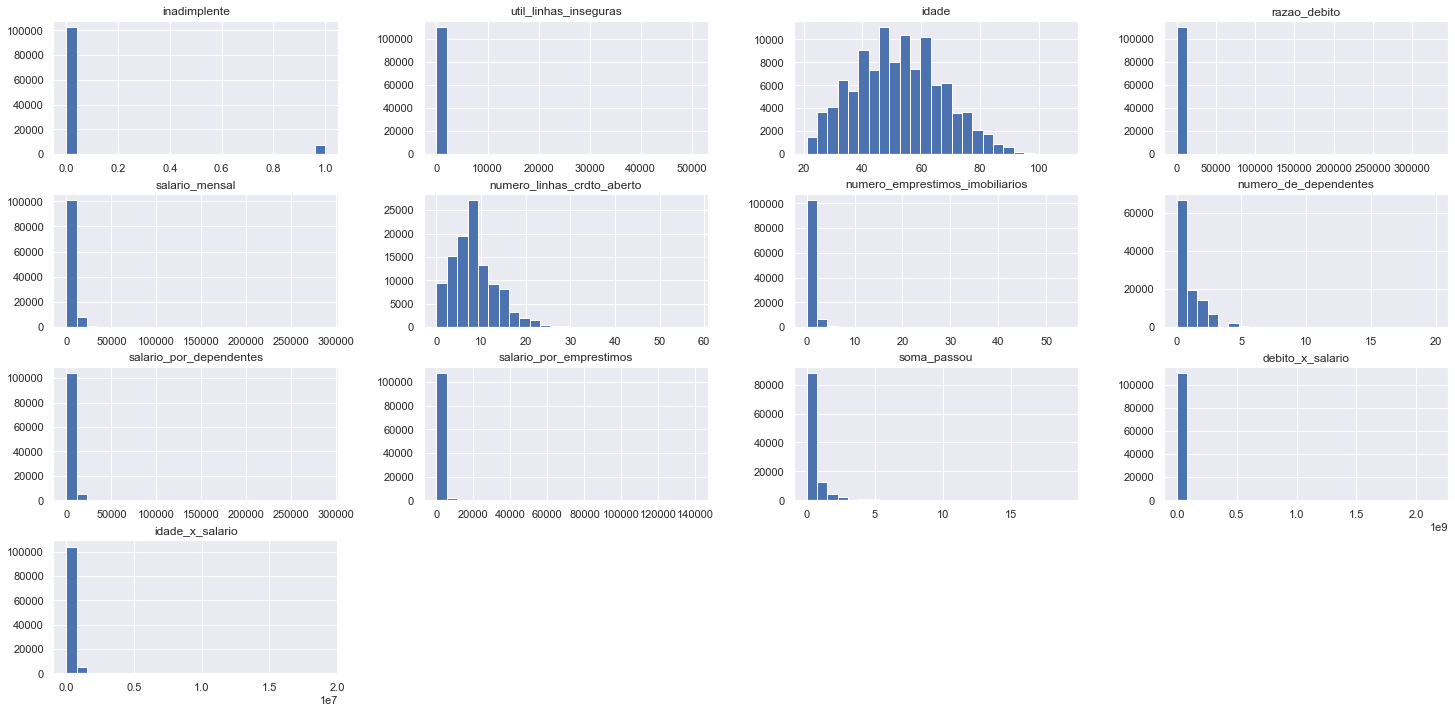

In [36]:
df4.hist( bins=25 );

### 4.1.3 Numerical Variable Boxplot

#### 4.1.3.1 Util Linhas Inseguras

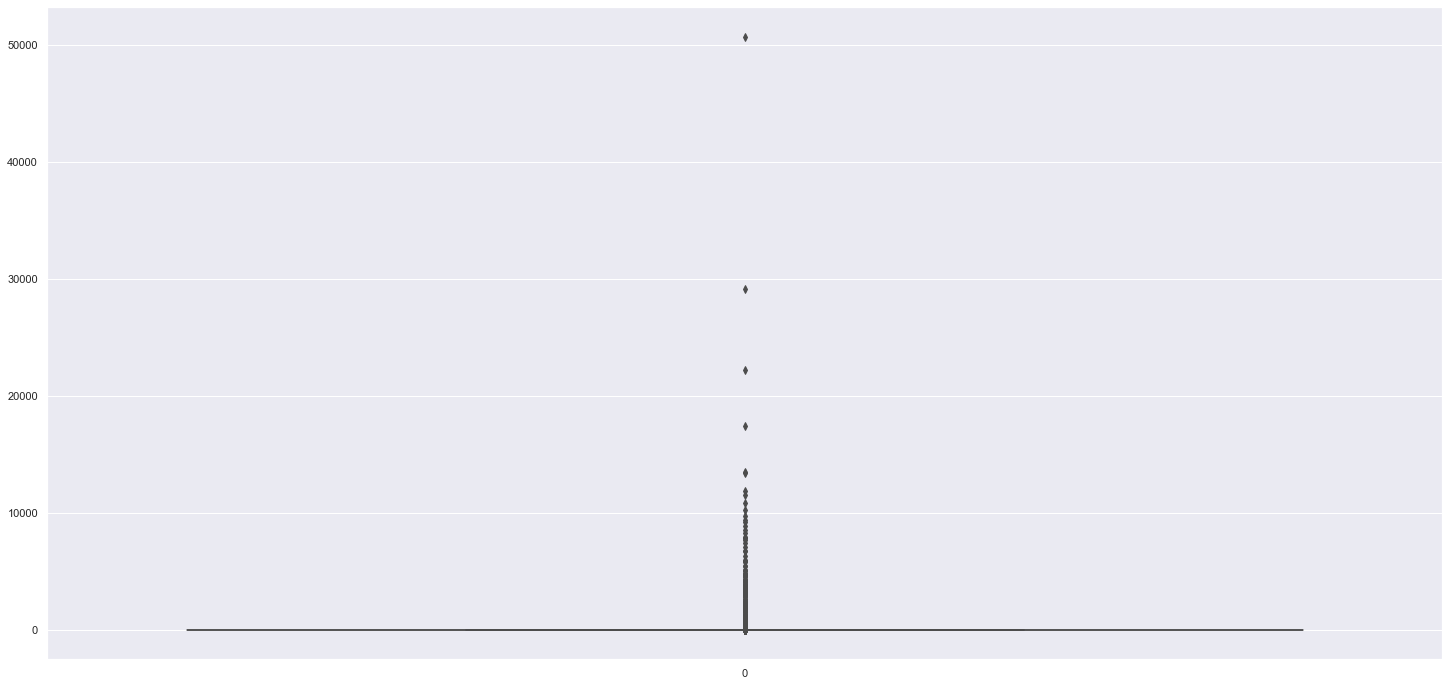

In [37]:
sns.boxplot( df4['util_linhas_inseguras'] );

#### 4.1.3.2 Idade

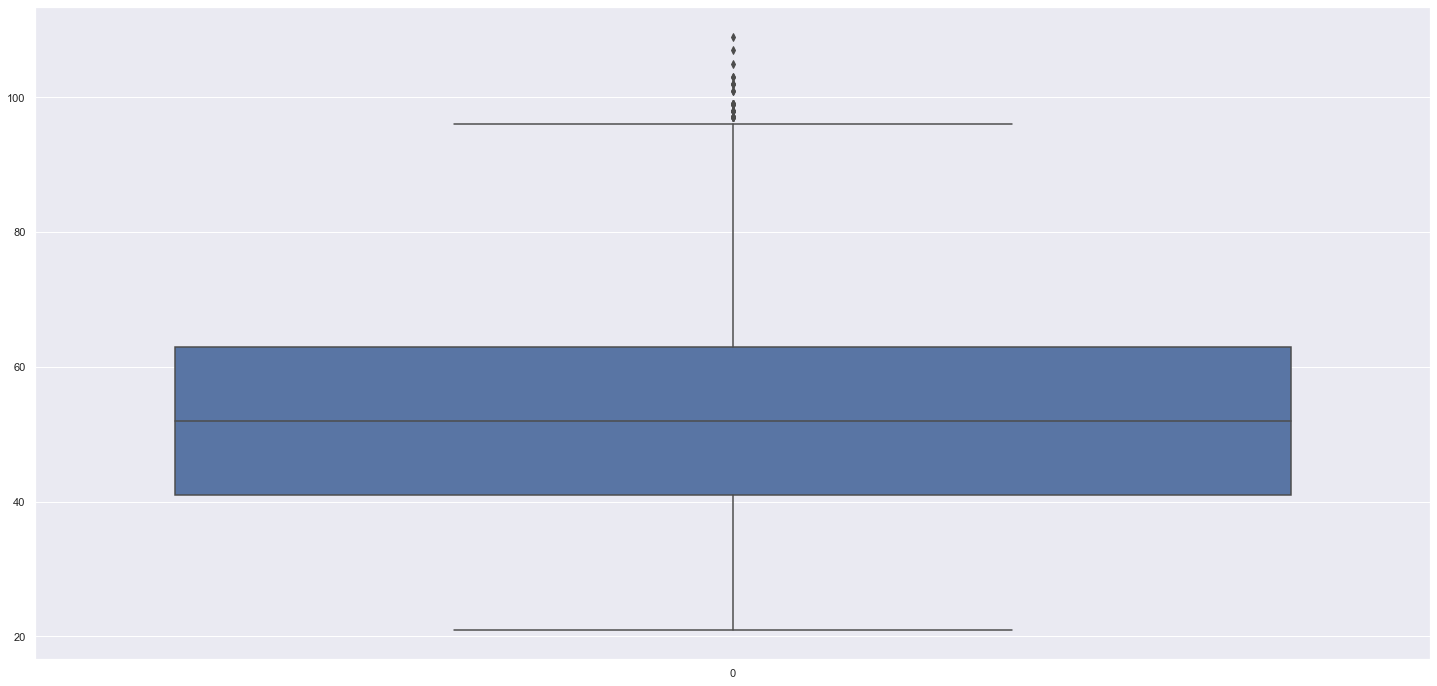

In [38]:
sns.boxplot( df4['idade'] );

#### 4.1.3.3 Razao Debito

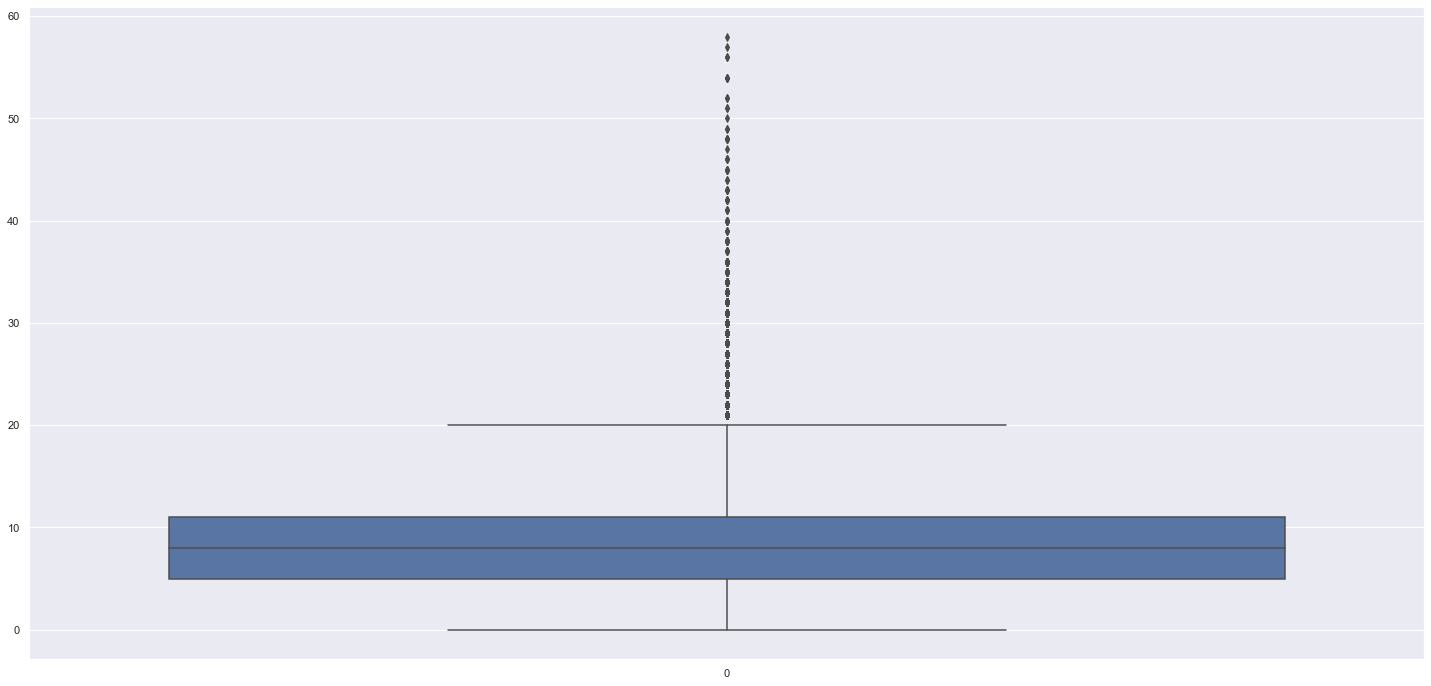

In [39]:
sns.boxplot( df4['numero_linhas_crdto_aberto'] );

#### 4.1.3.4 Numero Emprestimos Imobiliarios

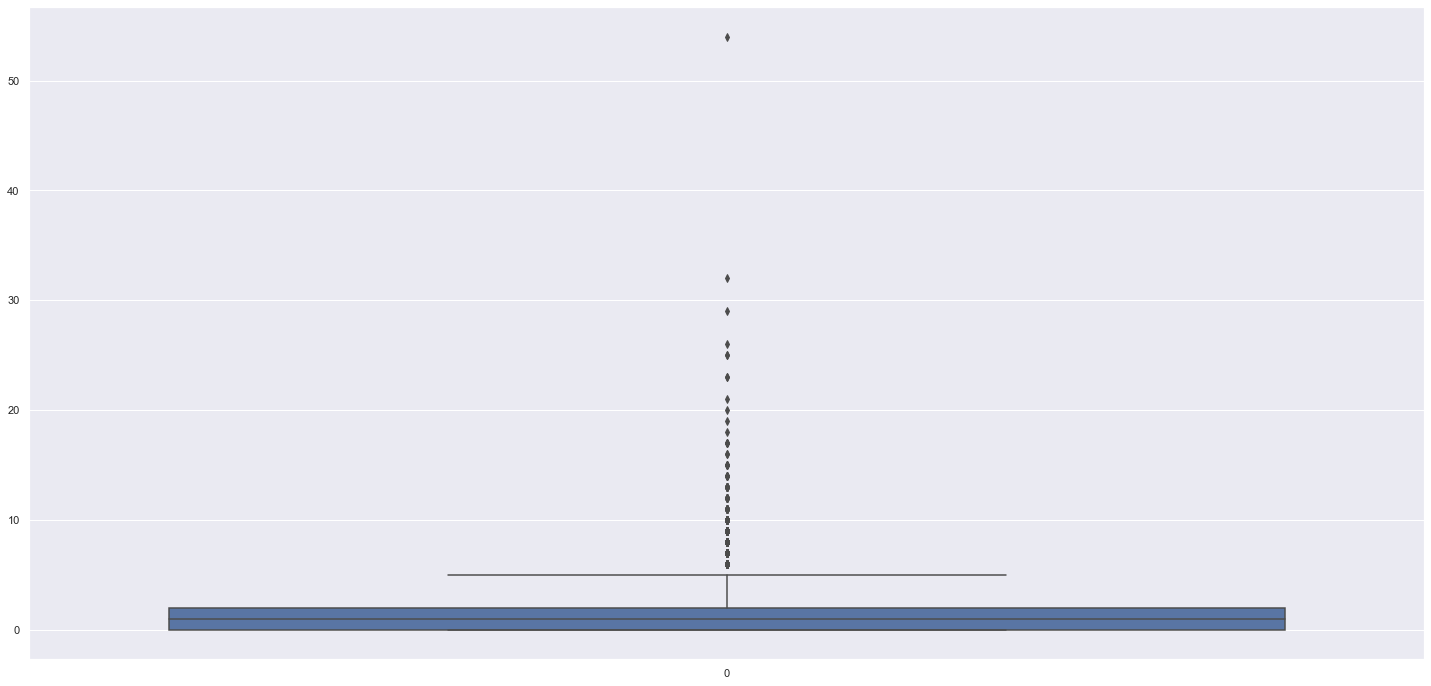

In [40]:
sns.boxplot( df4['numero_emprestimos_imobiliarios'] );

#### 4.1.3.5 Numero de Dependentes

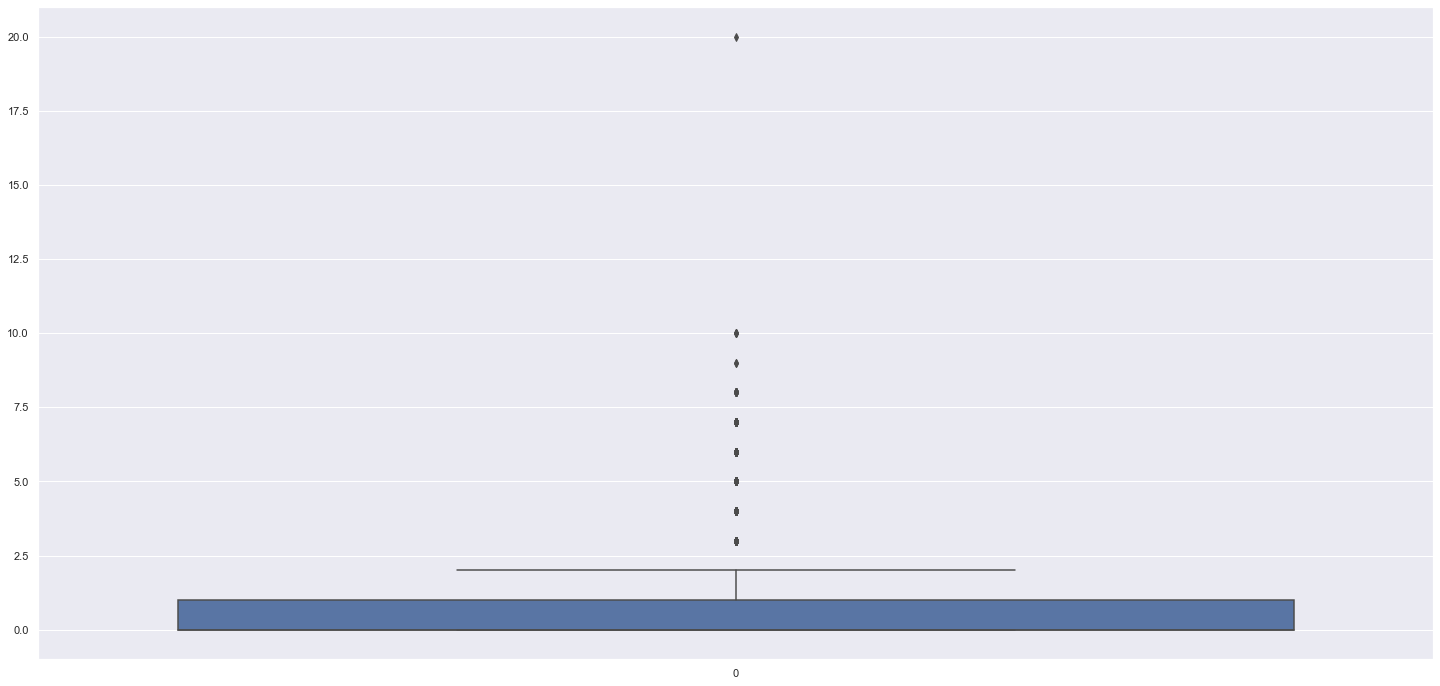

In [41]:
sns.boxplot( df4['numero_de_dependentes'] );

In [42]:
df4.loc[df4['salario_por_dependentes'] > 250000]

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_emprestimos_imobiliarios,numero_de_dependentes,salario_por_dependentes,salario_por_emprestimos,soma_passou,debito_x_salario,idade_x_salario
17373,0,1.000000,34,0.004304,251608.0,6,1,0,251608.0,41934.666667,1,1082.995811,8554672.0
43344,0,0.151357,59,0.011941,287662.0,9,5,1,287662.0,31962.444444,0,3434.988051,16972058.0


#### 4.1.3.6 Salario por Dependentes

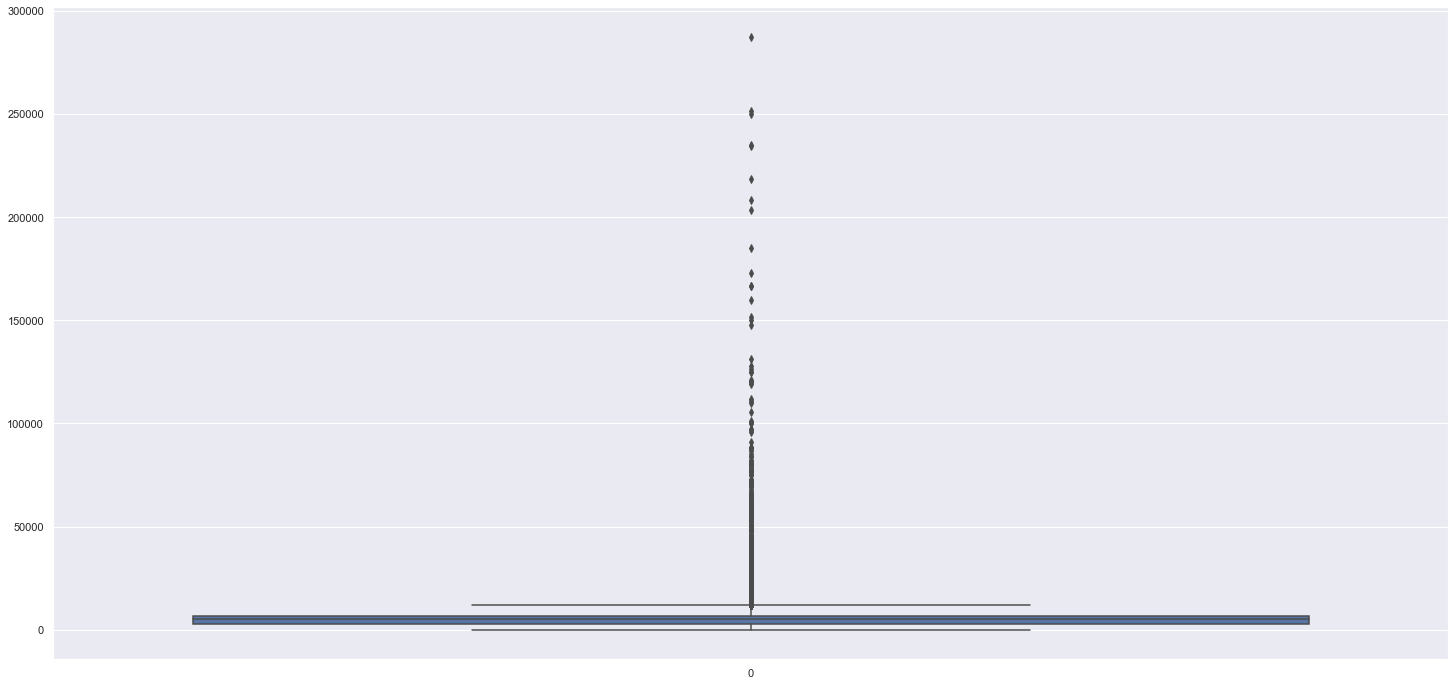

In [43]:
sns.boxplot( df4['salario_por_dependentes'] );

#### 4.1.3.7 Salario por Emprestimos

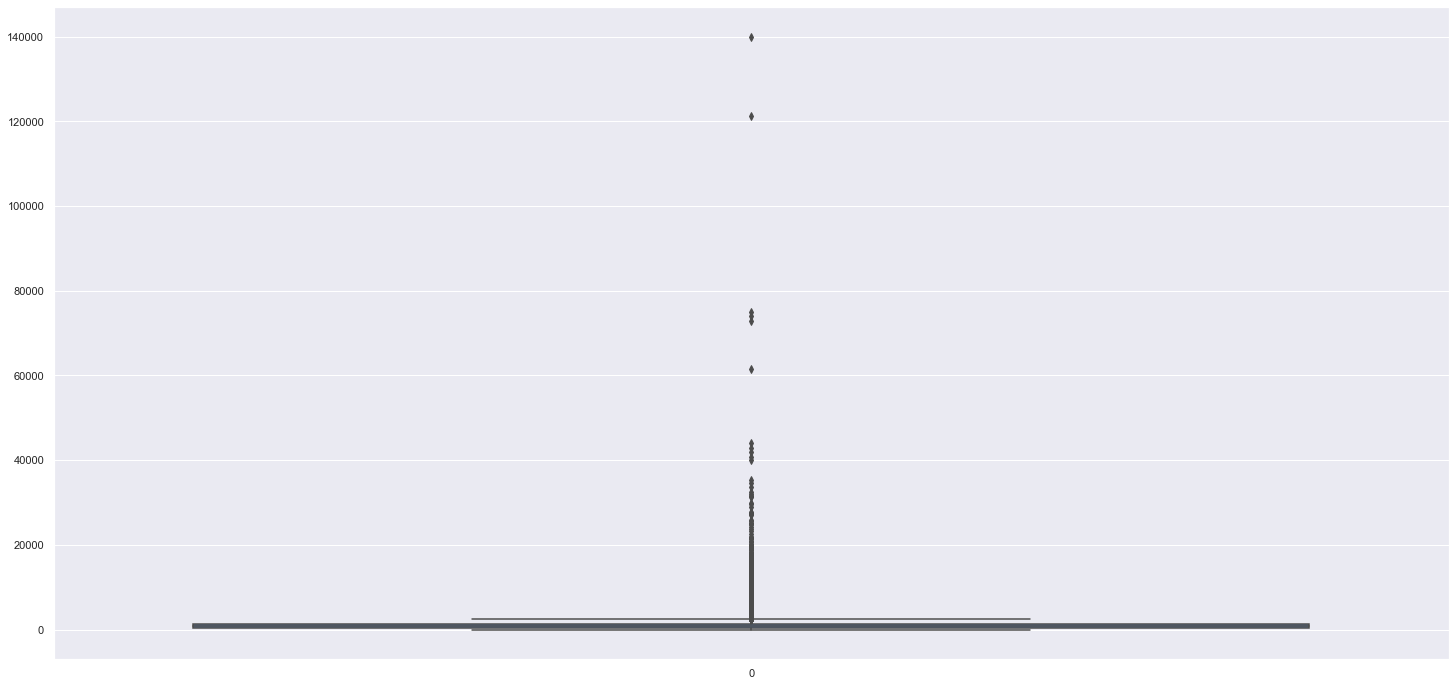

In [44]:
sns.boxplot( df4['salario_por_emprestimos'] );

#### 4.1.3.8 Soma Passou

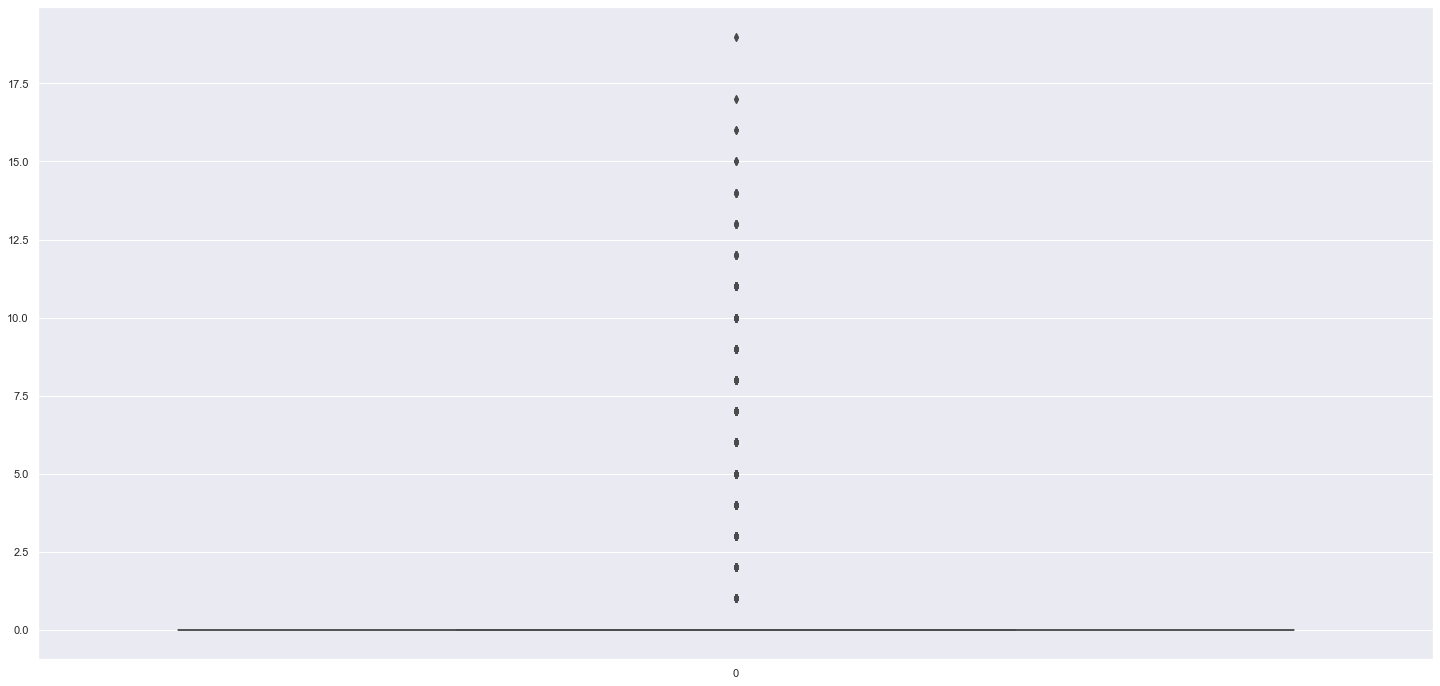

In [45]:
sns.boxplot( df4['soma_passou'] );
# Excluir outliers de prováveis erros de input manual das variáveis passou x dias

In [46]:
df4.loc[df4['soma_passou'] > 280]

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_emprestimos_imobiliarios,numero_de_dependentes,salario_por_dependentes,salario_por_emprestimos,soma_passou,debito_x_salario,idade_x_salario


#### 4.1.3.9 Debito x Salario

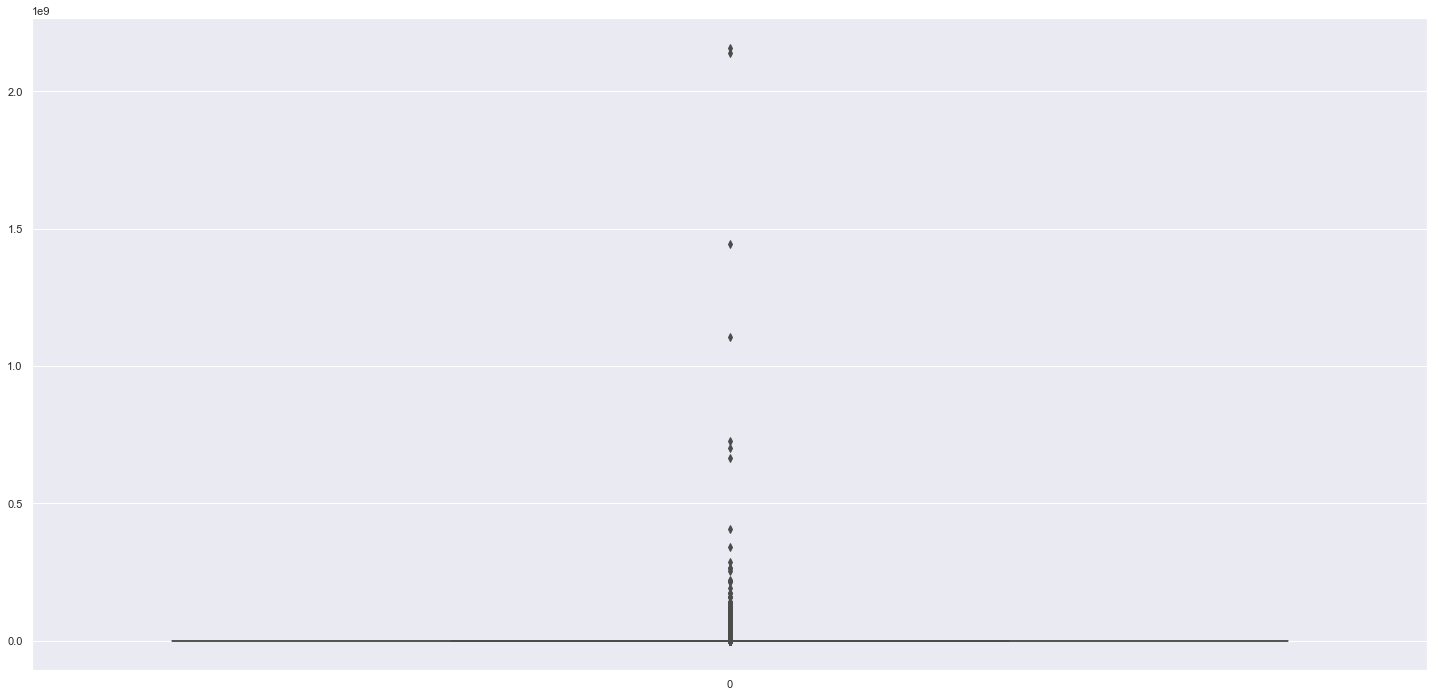

In [47]:
sns.boxplot( df4['debito_x_salario'] );

#### 4.1.3.10 Idade x Salario

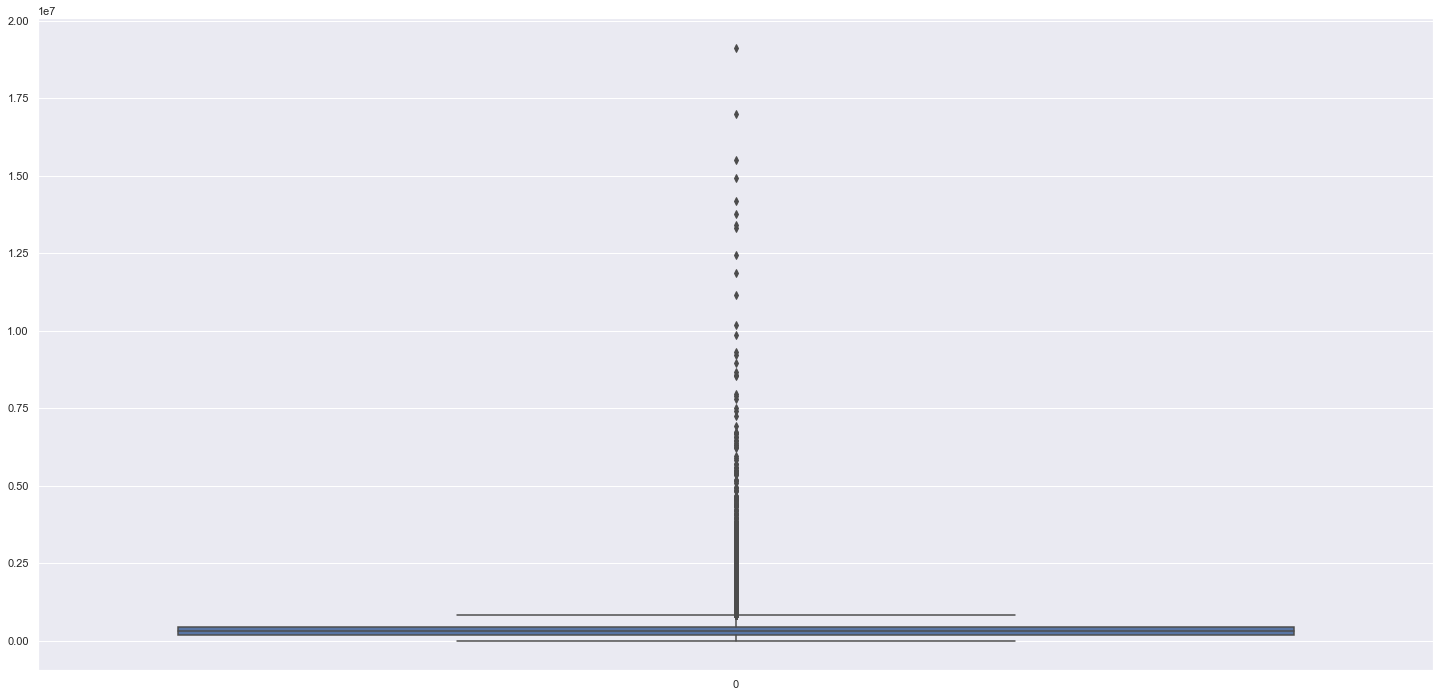

In [48]:
sns.boxplot( df4['idade_x_salario'] );

#### 4.1.3.11 Salario Mensal

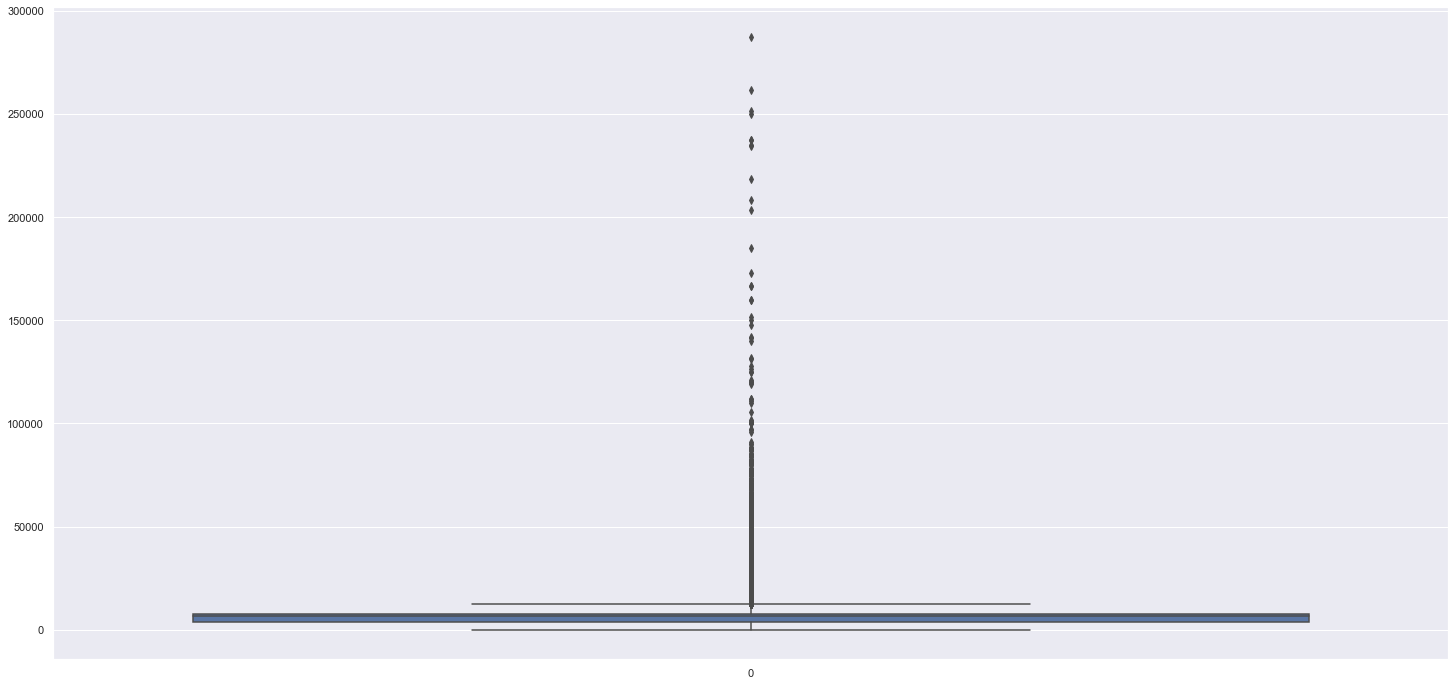

In [49]:
sns.boxplot( df4['salario_mensal'] );

#### 4.1.3.12 Numero Linhas Crdto Aberto

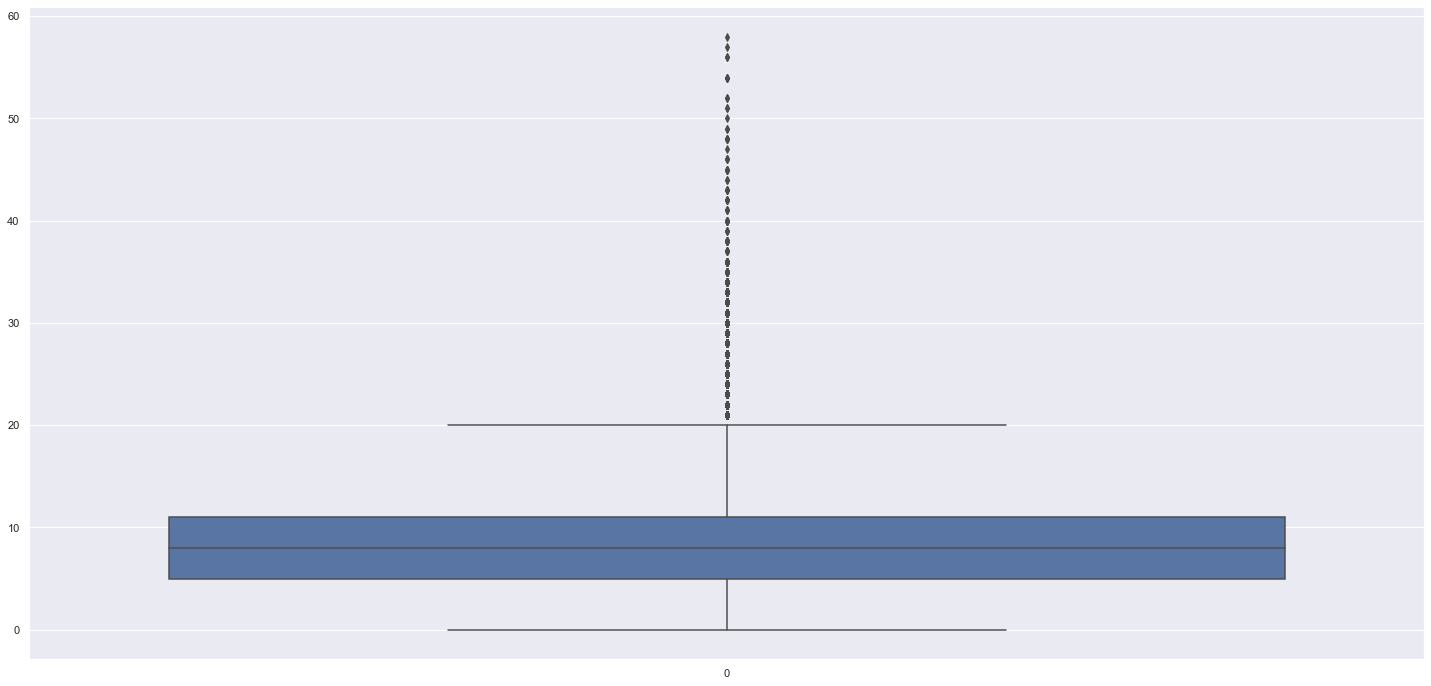

In [50]:
sns.boxplot( df4['numero_linhas_crdto_aberto'] );

## 4.2 Bivariate Analysis

### **H1.** Clientes com razão débito maior, são mais inadimplentes do que clientes com razão débito menor.
**FALSA:** Clientes com maior razão débito, são menos inadimplentes do que cliente com razão menor.

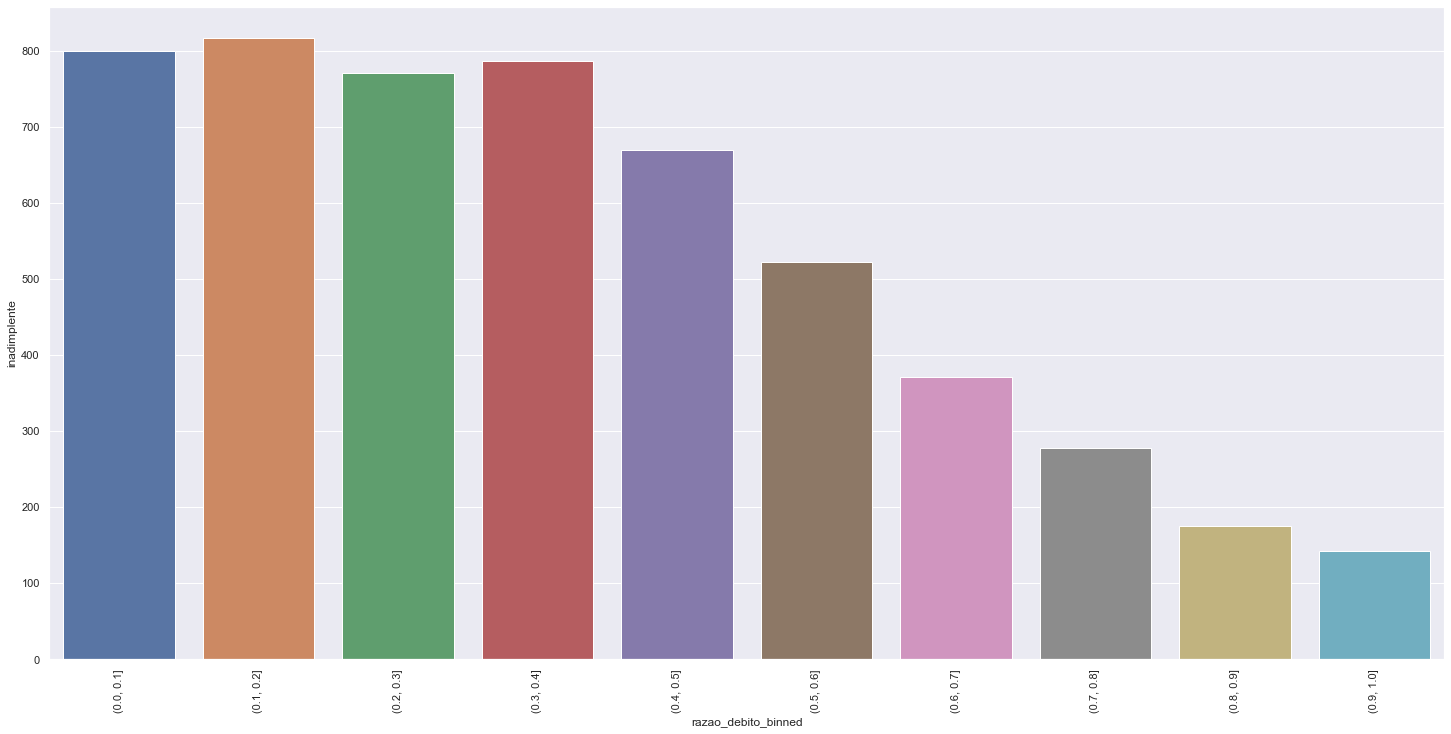

In [51]:
bins = list( arange( 0, 1.1, 0.1 ) )

df_aux = df4.loc[ df4['inadimplente'] == 1, : ]
df_aux1 = df_aux[['razao_debito', 'inadimplente']].groupby( 'razao_debito' ).count().reset_index()
df_aux1['razao_debito_binned'] = pd.cut( df_aux1['razao_debito'], bins=bins )
aux2 = df_aux1[['razao_debito_binned', 'inadimplente']].groupby( 'razao_debito_binned' ).count().reset_index()

sns.barplot( x='razao_debito_binned', y='inadimplente', data=aux2 );
plt.xticks( rotation=90 );

### **H2.** Clientes com número de dependentes maiores, são mais inadimplentes do que clientes com números menores.
**FALSA:** Clientes com maiores números de dependentes são menos inadimplentes do que clientes com números menores de dependentes.

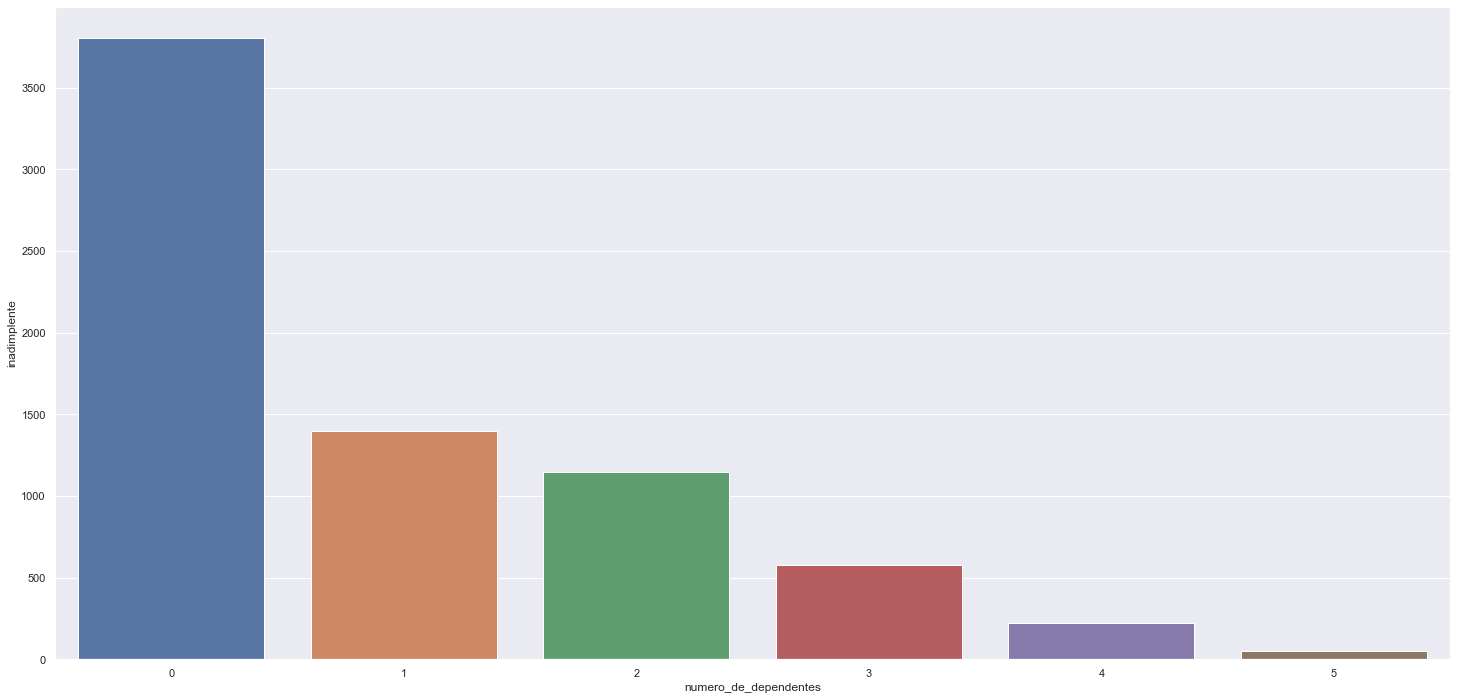

In [52]:
df_aux = df4.loc[ ( df4['inadimplente'] == 1 ) & ( df4['numero_de_dependentes'] <= 5 ), : ]
df_aux1 = df_aux[['numero_de_dependentes', 'inadimplente']].groupby( 'numero_de_dependentes' ).count().reset_index()
sns.barplot( x='numero_de_dependentes', y='inadimplente', data=df_aux1 );

### **H3.** Clientes mais velhos são menos inadimplentes do que clientes mais novos.
**VERDADEIRA:** A inadimplência crescre até a idade de 46 anos, e após isso os clientes mais velhos são menos inadimplentes.

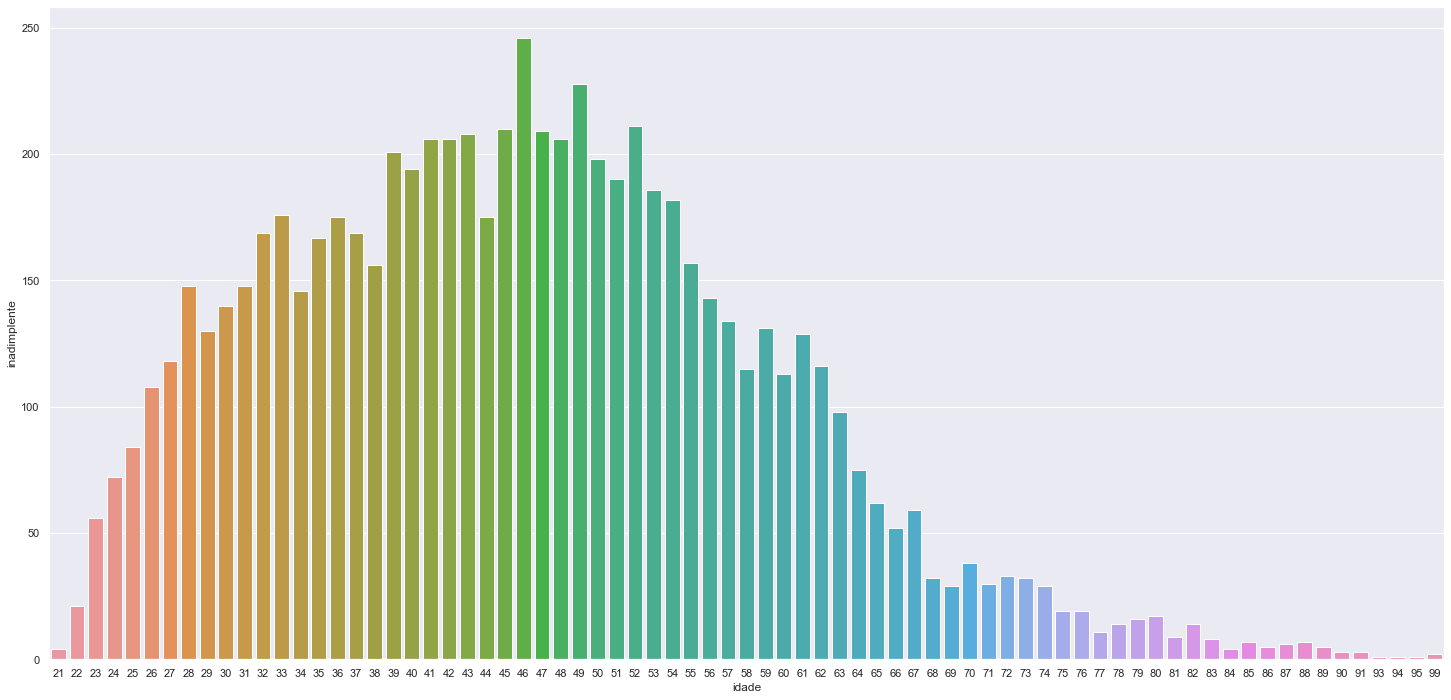

In [53]:
df_aux = df4.loc[ df4['inadimplente'] == 1 , : ]
df_aux1 = df_aux[['idade', 'inadimplente']].groupby( 'idade' ).count().reset_index()
sns.barplot( x='idade', y='inadimplente', data=df_aux1 );

### **H4.** Clientes com salários maiores são menos inadimplentes do que clientes com salários menores.
**VERDADEIRA:** A inadimplência cresce até o salário de 3000 à 3500, após isso ela diminui conforme o salário cresce.

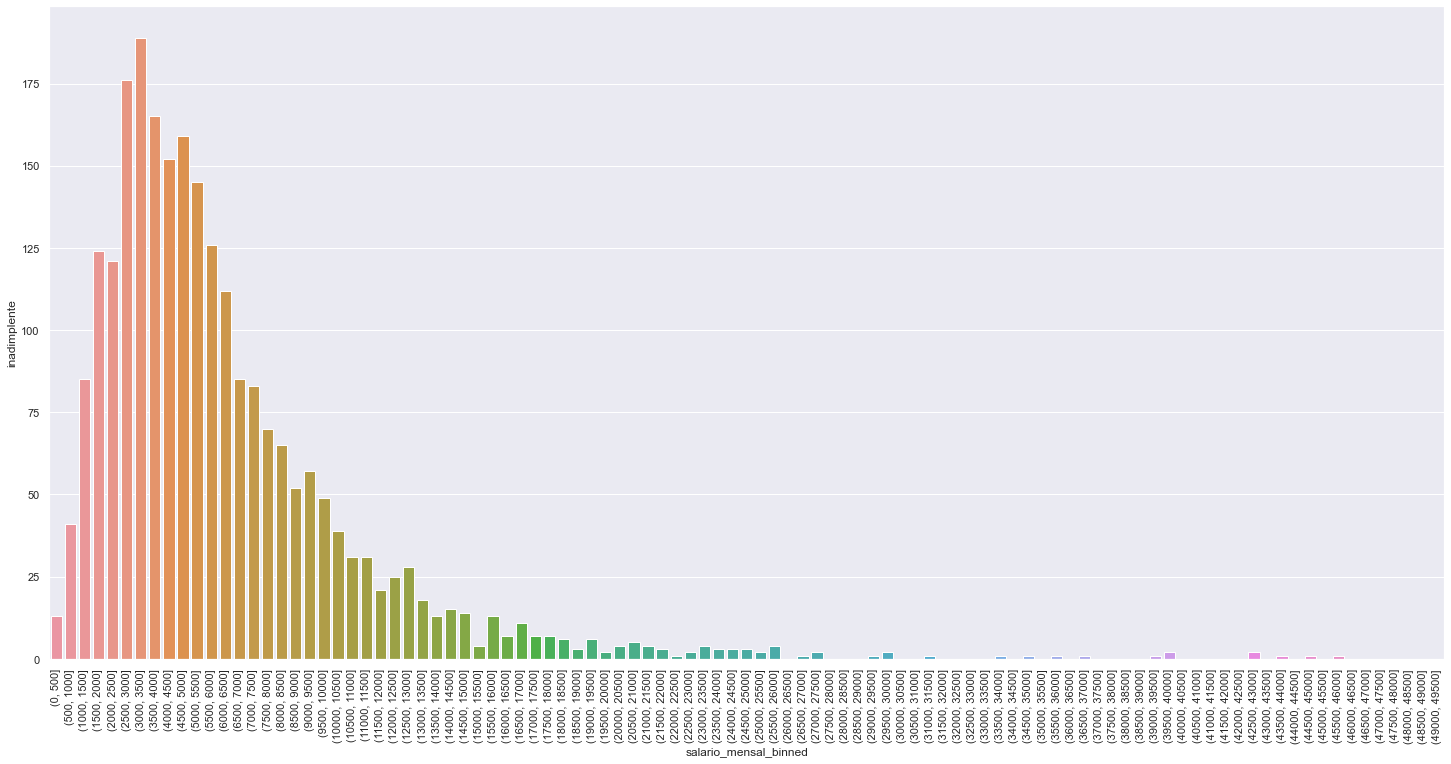

In [54]:
bins = list( arange( 0, 50000, 500 ) )

df_aux = df4.loc[ df4['inadimplente'] == 1, : ]
df_aux1 = df_aux[['salario_mensal', 'inadimplente']].groupby( 'salario_mensal' ).count().reset_index()
df_aux1['salario_mensal_binned'] = pd.cut( df_aux1['salario_mensal'], bins=bins )
aux2 = df_aux1[['salario_mensal_binned', 'inadimplente']].groupby( 'salario_mensal_binned' ).count().reset_index()

sns.barplot( x='salario_mensal_binned', y='inadimplente', data=aux2 );
plt.xticks( rotation=90 );

### H5. Clientes com maiores números de empréstimos abertos, são mais inadimplentes do que clientes com menos empréstimos abertos.
**FALSO:** A inadimplência cresce apenas até 5 empréstimos abertos, após isso diminui conforme os empréstimos aumentam.

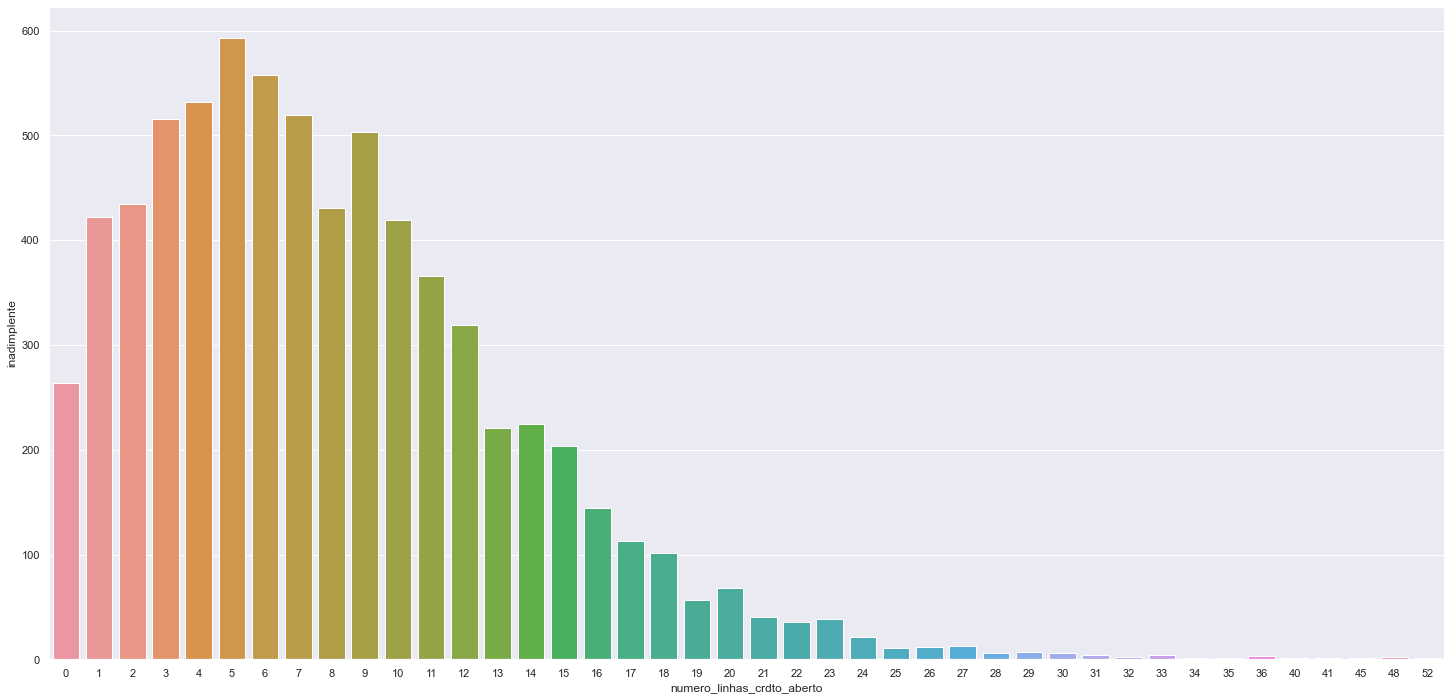

In [55]:
df_aux = df4.loc[ df4['inadimplente'] == 1 , : ]
df_aux1 = df_aux[['numero_linhas_crdto_aberto', 'inadimplente']].groupby( 'numero_linhas_crdto_aberto' ).count().reset_index()
sns.barplot( x='numero_linhas_crdto_aberto', y='inadimplente', data=df_aux1 );

### H6. Clientes com maior quantidade de empréstimos sem garantia são mais inadimplentes do que clientes com menores quantidades de empréstimos sem garantia.
**VERDADEIRA:** Clientes com valores maiores de linhas de empréstimos sem a garantia de algum bem, são mais inadimplentes do que clientes com menores quantidades de linhas sem garantia.

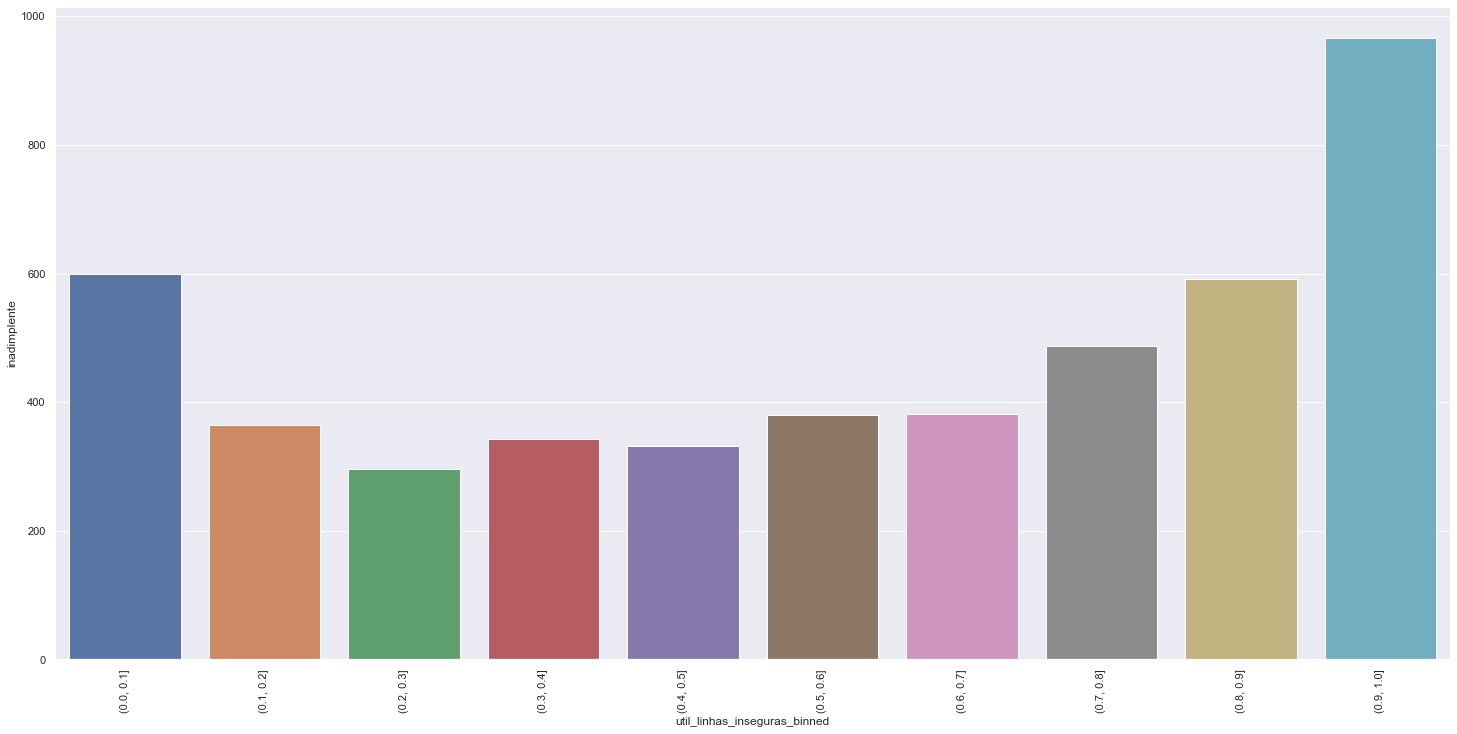

In [56]:
bins = list( arange( 0, 1.1, 0.1 ) )

df_aux = df4.loc[ df4['inadimplente'] == 1, : ]
df_aux1 = df_aux[['util_linhas_inseguras', 'inadimplente']].groupby( 'util_linhas_inseguras' ).count().reset_index()
df_aux1['util_linhas_inseguras_binned'] = pd.cut( df_aux1['util_linhas_inseguras'], bins=bins )
aux2 = df_aux1[['util_linhas_inseguras_binned', 'inadimplente']].groupby( 'util_linhas_inseguras_binned' ).count().reset_index()

sns.barplot( x='util_linhas_inseguras_binned', y='inadimplente', data=aux2 );
plt.xticks( rotation=90 );

## 4.3 Multivariate Analysis

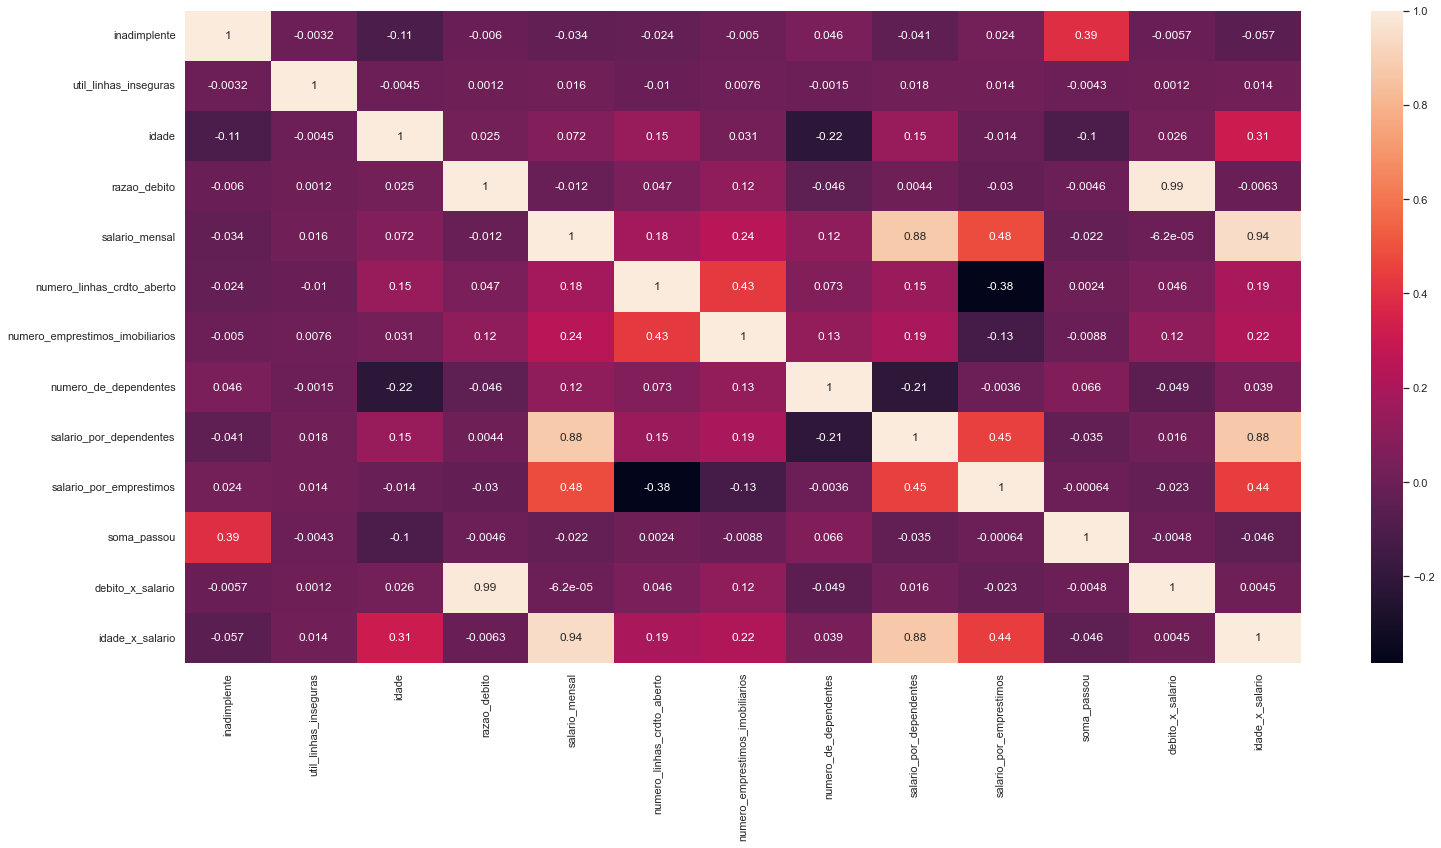

In [57]:
correlation = df4.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.1 Exclude High Correlation Variables

In [58]:
# soma_passou x vezes_passou_de_30_59_dias x numero_vezes_passou_90_dias x numero_de_vezes_que_passou_60_89_dias
# As 3 variáveis iniciais já são altamente correlacionadas e manter apenas uma delas, haveria perda de informação, por isso será mantida a variável criada com a soma das 3 iniciais.

In [59]:
# linhas_credito_inseguras x util_linhas_inseguras, será mantida a variável inicial.

# 5.0 DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1 Balanced Dataset

### 5.1.1 Random Oversampling

In [61]:
# # Define Sampler
# oversampling = overs.RandomOverSampler( sampling_strategy='minority', random_state=42 )

# # Apply Sampler
# X_over, y_over = oversampling.fit_resample( df5, df5['inadimplente'] )

In [62]:
# df5 = X_over.copy()

### 5.1.2 SMOTE + TOMEK LINK

In [63]:
# Define Sampler
smt = c.SMOTETomek( sampling_strategy='minority', random_state=42 )

# Apply Sampler
X_smt, y_smt = smt.fit_resample( df5, df5['inadimplente'] )

In [64]:
df5 = X_smt.copy()

## 5.2 Standard/Encoder/Scaler

In [65]:
# ======================== StandardScaler ========================

# Idade
idade_standard = StandardScaler()
df5['idade'] = idade_standard.fit_transform( df5[['idade']].values )
pickle.dump( idade_standard, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/idade_standard.pkl', 'wb' ) )

# ======================== MinMaxScaler ========================

# # Razao Debito
# razao_debito_min_max = MinMaxScaler()
# df5['razao_debito'] = razao_debito_min_max.fit_transform( df5[['razao_debito']].values )
# pickle.dump( razao_debito_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/razao_debito_min_max.pkl', 'wb' ) )


# # Numero Emprestimos Imobiliarios
# numero_emprestimos_imobiliarios_min_max = MinMaxScaler()
# df5['numero_emprestimos_imobiliarios'] = numero_emprestimos_imobiliarios_min_max.fit_transform( df5[['numero_emprestimos_imobiliarios']].values )
# pickle.dump( numero_emprestimos_imobiliarios_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/numero_emprestimos_imobiliarios_min_max.pkl', 'wb' ) )


# # Numero de Dependentes
# numero_de_dependentes_min_max = MinMaxScaler()
# df5['numero_de_dependentes'] = numero_de_dependentes_min_max.fit_transform( df5[['numero_de_dependentes']].values )
# pickle.dump( numero_de_dependentes_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/numero_de_dependentes_min_max.pkl', 'wb' ) )


# Salario por Dependentes
salario_por_dependentes_min_max = MinMaxScaler()
df5['salario_por_dependentes'] = salario_por_dependentes_min_max.fit_transform( df5[['salario_por_dependentes']].values )
pickle.dump( salario_por_dependentes_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/salario_por_dependentes_min_max.pkl', 'wb' ) )


# Soma Passou
soma_passou_min_max = MinMaxScaler()
df5['soma_passou'] = soma_passou_min_max.fit_transform( df5[['soma_passou']].values )
pickle.dump( soma_passou_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/soma_passou_min_max.pkl', 'wb' ) )

# # Numero Linhas Crdto Aberto
# numero_linhas_crdto_aberto_min_max = MinMaxScaler()
# df5['numero_linhas_crdto_aberto'] = numero_linhas_crdto_aberto_min_max.fit_transform( df5[['numero_linhas_crdto_aberto']].values )
# pickle.dump( numero_linhas_crdto_aberto_min_max, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/numero_linhas_crdto_aberto_min_max.pkl', 'wb' ) )

# ======================== RobustScaler ========================
# Util Linhas Inseguras
util_linhas_inseguras_robust = RobustScaler()
df5['util_linhas_inseguras'] = util_linhas_inseguras_robust.fit_transform( df5[['util_linhas_inseguras']].values )
pickle.dump( util_linhas_inseguras_robust, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/util_linhas_inseguras_robust.pkl', 'wb' ) )


# # Salario por Emprestimos
# salario_por_emprestimos_robust = RobustScaler()
# df5['salario_por_emprestimos'] = salario_por_emprestimos_robust.fit_transform( df5[['salario_por_emprestimos']].values )
# pickle.dump( salario_por_emprestimos_robust, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/salario_por_emprestimos_robust.pkl', 'wb' ) )


# Debito x Salario
debito_x_salario_robust = RobustScaler()
df5['debito_x_salario'] = debito_x_salario_robust.fit_transform( df5[['debito_x_salario']].values )
pickle.dump( debito_x_salario_robust, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/debito_x_salario_robust.pkl', 'wb' ) )


# Idade x Salario
idade_x_salario_robust = RobustScaler()
df5['idade_x_salario'] = idade_x_salario_robust.fit_transform( df5[['idade_x_salario']].values )
pickle.dump( idade_x_salario_robust, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/idade_x_salario_robust.pkl', 'wb' ) )

# # Salario Mensal
# salario_mensal_robust = RobustScaler()
# df5['salario_mensal'] = salario_mensal_robust.fit_transform( df5[['salario_mensal']].values )
# pickle.dump( salario_mensal_robust, open( '/home/jeffsmedines/repos/datarisk_credit/parameter/salario_mensal_robust.pkl', 'wb' ) )

# 6.0 FEATURE SELECTION

In [66]:
df6 = df5.copy()

## 6.1 Boruta as Feature Selector

In [67]:
# # Training and Test dataset for Boruta
# X_train_n = X_train.values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.1.1 Best Features From Boruta

In [68]:
# # Boruta Rank
# cols_selected = boruta.support_.tolist()

# # Best Features
# X_train_fs = X_train
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Not Selected Boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.2 Manual Feature Selection

In [69]:
# Important Features by Boruta
cols_selected_boruta = [
    'util_linhas_inseguras',
    'idade',
    'salario_por_dependentes',
    'salario_por_emprestimos',
    'soma_passou',
    'debito_x_salario',
    'idade_x_salario' 
]

In [70]:
# Not Important Features by Boruta
cols_not_selected_boruta = [
    'numero_de_dependentes',
    'numero_emprestimos_imobiliarios',
    'numero_linhas_crdto_aberto',
    'razao_debito',
    'salario_mensal']

In [71]:
# Important Features by EDA
cols_to_add = [
    
]

In [72]:
# Final Features
cols_selected_boruta.extend( cols_to_add )

In [73]:
df6.shape

(197514, 13)

## 6.3 Split Dataframe Into Training and Validation Dataset

In [74]:
# Split
X = df6[ cols_selected_boruta ].copy()
y = df6['inadimplente'].copy()
X_train, X_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

# Production
X_production = df6[ cols_selected_boruta ].copy()
y_production = df6['inadimplente'].copy()

In [75]:
X_train.head()

,util_linhas_inseguras,idade,salario_por_dependentes,salario_por_emprestimos,soma_passou,debito_x_salario,idade_x_salario
75566,-0.566337,0.057278,0.007590,935.780442,0.0,2665.275124,0.261657
102576,-0.279002,-1.159739,0.017382,416.666667,0.0,-0.268347,-0.405262
79054,-0.563649,1.918598,0.022771,935.780442,0.0,77.171084,0.960538
15582,-0.563459,0.558402,0.028342,815.300000,0.0,0.293380,0.824653
66912,-0.366147,1.274295,0.027463,607.692308,0.0,-0.049092,1.089655


# 7.0 MACHINE LEARNING MODELLING

In [124]:
df7 = df6[ cols_selected_boruta ].copy()

## 7.1 Baseline

In [125]:
# Model Predict
class_list = [0, 1]
yhat_baseline = rd.choices( class_list, weights=(93, 7), k=len(y_validation) )

# Model Performance
precision = m.precision_score( y_validation, yhat_baseline )
recall = m.recall_score( y_validation, yhat_baseline )
f1_score = m.f1_score( y_validation, yhat_baseline )

# Performance Df
baseline_single = pd.DataFrame( {'Model Name': 'Baseline',
                             'PRECISION': round(precision, 4),
                             'RECALL': round(recall, 4),
                             'F1 SCORE': round(f1_score, 4)}, index=[0] )
baseline_single

,Model Name,PRECISION,RECALL,F1 SCORE
0,Baseline,0.5071,0.0702,0.1234


In [126]:
baseline_cv = pd.DataFrame( {'Model Name': 'Baseline',
                             'PRECISION CV': round(precision, 4).astype( str ),
                             'RECALL CV': round(recall, 4).astype( str ),
                             'F1 SCORE CV': round(f1_score, 4).astype( str )}, index=[0] )
baseline_cv

,Model Name,PRECISION CV,RECALL CV,F1 SCORE CV
0,Baseline,0.5071,0.0702,0.1234


## 7.2 Random Forest

In [127]:
# Model Definition
rf_model = RandomForestClassifier( random_state=42 )

# Model Training
rf_model.fit( X_train, y_train )

# Model Predict
yhat_rf = rf_model.predict( X_validation )

# Model Performance
precision = m.precision_score( y_validation, yhat_rf )
recall = m.recall_score( y_validation, yhat_rf )
f1_score = m.f1_score( y_validation, yhat_rf )

# Performance Df
rf_single = pd.DataFrame( {'Model Name': 'Random Forest',
                             'PRECISION': round(precision, 4),
                             'RECALL': round(recall, 4),
                             'F1 SCORE': round(f1_score, 4)}, index=[0] )
rf_single

,Model Name,PRECISION,RECALL,F1 SCORE
0,Random Forest,0.8704,0.9178,0.8935


### 7.2.1 Real Performance - Cross Validation

In [128]:
# Cross Validation
rf_cv = cross_validate( RandomForestClassifier( random_state=42 ), X_train, y_train, cv=5, scoring=[ 'precision', 'recall', 'f1' ] )

# CV Dataframe
df_rf_cv = pd.DataFrame( {'Model Name': 'Random Forest',
                             'PRECISION CV': round( np.mean( rf_cv['test_precision'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( rf_cv['test_precision'] ) , 4 ).astype( str ),
                             'RECALL CV': round( np.mean( rf_cv['test_recall'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( rf_cv['test_recall'] ) , 4 ).astype( str ),
                             'F1 SCORE CV': round( np.mean( rf_cv['test_f1'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( rf_cv['test_f1'] ) , 4 ).astype( str )}, index=[0] )
df_rf_cv

,Model Name,PRECISION CV,RECALL CV,F1 SCORE CV
0,Random Forest,0.8572 +/- 0.0013,0.904 +/- 0.0018,0.8799 +/- 0.0005


## 7.3 Decision Tree

In [129]:
# Model Definition
dt_model = DecisionTreeClassifier( random_state=42 )

# Model Training
dt_model.fit( X_train, y_train )

# Model Predict
yhat_dt = dt_model.predict( X_validation )

# Model Performance
precision = m.precision_score( y_validation, yhat_dt )
recall = m.recall_score( y_validation, yhat_dt )
f1_score = m.f1_score( y_validation, yhat_dt )

# Performance Df
dt_single = pd.DataFrame( {'Model Name': 'Decision Tree',
                             'PRECISION': round(precision, 4),
                             'RECALL': round(recall, 4),
                             'F1 SCORE': round(f1_score, 4)}, index=[0] )
dt_single

,Model Name,PRECISION,RECALL,F1 SCORE
0,Decision Tree,0.8077,0.8427,0.8249


### 7.3.1 Real Performance - Cross Validation

In [130]:
# Cross validation
dt_cv = cross_validate( DecisionTreeClassifier( random_state=42 ), X_train, y_train, cv=5, scoring=[ 'precision', 'recall', 'f1' ] )

# CV Dataframe
df_dt_cv = pd.DataFrame( {'Model Name': 'Decision Tree',
                             'PRECISION CV': round( np.mean( dt_cv['test_precision'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( dt_cv['test_precision'] ) , 4 ).astype( str ),
                             'RECALL CV': round( np.mean( dt_cv['test_recall'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( dt_cv['test_recall'] ) , 4 ).astype( str ),
                             'F1 SCORE CV': round( np.mean( dt_cv['test_f1'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( dt_cv['test_f1'] ) , 4 ).astype( str )}, index=[0] )
df_dt_cv

,Model Name,PRECISION CV,RECALL CV,F1 SCORE CV
0,Decision Tree,0.799 +/- 0.0026,0.8304 +/- 0.0029,0.8144 +/- 0.0018


## 7.4 XGBoost

In [78]:
# Model Definition
# 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 2500, 'subsample': 1
xgb_model = XGBClassifier( random_state=42 )

# Model Training
xgb_model.fit( X_train, y_train )

# Model Predict
yhat_xgb = xgb_model.predict( X_validation )

# Model Performance
precision = m.precision_score( y_validation, yhat_xgb )
recall = m.recall_score( y_validation, yhat_xgb )
f1_score = m.f1_score( y_validation, yhat_xgb )

# Performance Df
xgb_single = pd.DataFrame( {'Model Name': 'XGBoost',
                             'PRECISION': round(precision, 4),
                             'RECALL': round(recall, 4),
                             'F1 SCORE': round(f1_score, 4)}, index=[0] )
xgb_single

,Model Name,PRECISION,RECALL,F1 SCORE
0,XGBoost,0.8338,0.8666,0.8499


### 7.4.1 Real Performance - Cross Validation

In [79]:
# Cross Validation
xgb_cv = cross_validate( XGBClassifier( random_state=42 ), X_train, y_train, cv=5, scoring=[ 'precision', 'recall', 'f1' ] )

# CV Dataframe
df_xgb_cv = pd.DataFrame( {'Model Name': 'XGBoost',
                             'PRECISION CV': round( np.mean( xgb_cv['test_precision'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( xgb_cv['test_precision'] ) , 4 ).astype( str ),
                             'RECALL CV': round( np.mean( xgb_cv['test_recall'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( xgb_cv['test_recall'] ) , 4 ).astype( str ),
                             'F1 SCORE CV': round( np.mean( xgb_cv['test_f1'] ) , 4 ).astype( str ) + ' +/- ' + round( np.std( xgb_cv['test_f1'] ) , 4 ).astype( str )}, index=[0] )
df_xgb_cv

,Model Name,PRECISION CV,RECALL CV,F1 SCORE CV
0,XGBoost,0.8313 +/- 0.0029,0.8661 +/- 0.0031,0.8483 +/- 0.0023


## 7.5 Compare Model's Performance

### 7.5.1 Single Performance

In [133]:
models_result = pd.concat( [baseline_single, rf_single, dt_single, xgb_single] )
models_result.sort_values( 'RECALL', ascending=False )

,Model Name,PRECISION,RECALL,F1 SCORE
0,Random Forest,0.8704,0.9178,0.8935
0,XGBoost,0.8362,0.8712,0.8533
0,Decision Tree,0.8077,0.8427,0.8249
0,Baseline,0.5071,0.0702,0.1234


### 7.5.2 Real Performance - Cross Validation

In [134]:
models_result_cv = pd.concat( [ df_rf_cv, df_dt_cv, df_xgb_cv, baseline_cv ] )
models_result_cv.sort_values( 'RECALL CV', ascending=False )

,Model Name,PRECISION CV,RECALL CV,F1 SCORE CV
0,Random Forest,0.8572 +/- 0.0013,0.904 +/- 0.0018,0.8799 +/- 0.0005
0,XGBoost,0.8304 +/- 0.0021,0.8659 +/- 0.0022,0.8478 +/- 0.0016
0,Decision Tree,0.799 +/- 0.0026,0.8304 +/- 0.0029,0.8144 +/- 0.0018
0,Baseline,0.5071,0.0702,0.1234


# 8.0 HYPERPARAMETER FINE TUNING

In [135]:
df8 = df7.copy()

## 8.1 Random Search

### 8.1.1 Random Forest

In [136]:
# param = {  
#           'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 4], 
#           'n_estimators': range(50, 500, 50),
#           'criterion': ['gini', 'entropy']
# }

# MAX_EVAL = 50

In [137]:
# final_result = pd.DataFrame()
# for i in range( MAX_EVAL ):
#     print( f'Iteration Procces: {i}/{MAX_EVAL}' )
#     # Choose values for parameters randomly
#     hp = { k: rd.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     # Model
#     rf_model = RandomForestClassifier( min_samples_split=hp['min_samples_split'],
#                                        min_samples_leaf=hp['min_samples_leaf'],
#                                        max_depth=hp['max_depth'],
#                                        criterion=hp['criterion'],
#                                        n_estimators=hp['n_estimators'],
#                                        random_state=42,
#                                        n_jobs=-1)
    
    
#     rf_cv = pd.DataFrame( cross_validate( rf_model, X_train, y_train, cv=5, scoring=[ 'precision', 'recall', 'f1' ] ) )
    
#     final_result = pd.concat( [ final_result, rf_cv ] )
    
#     print( '=========================================================================================' )

### 8.1.2 XGBoost

In [138]:
# param = { 'n_estimators': [1500, 1700, 2500, 3000, 3500], 
#           'eta': [0.01, 0.5, 0.2], 
#           'max_depth': [3, 5, 9], 
#           'subsample': [0.1, 0.3, 0.5], 
#           'colsample_bytree': [0.3, 0.3, 0.5], 
#           'min_child_weight': [1, 3, 5, 7] 
#         }

# MAX_EVAL = 50

In [139]:
# final_result_xgb = pd.DataFrame()
# for i in range( MAX_EVAL ):
#     print( f'Iteration Procces: {i}/{MAX_EVAL}' )
#     # Choose values for parameters randomly
#     hp = { k: rd.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     # Model
#     xgb_model = XGBClassifier(     min_child_weight=hp['min_child_weight'],
#                                        colsample_bytree=hp['colsample_bytree'],
#                                        max_depth=hp['max_depth'],
#                                        eta=hp['eta'],
#                                        n_estimators=hp['n_estimators'],
#                                        subsample=hp['subsample'],
#                                        random_state=42,
#                                        n_jobs=-1)
    
    
#     xgb_cv = pd.DataFrame( cross_validate( xgb_model, X_train, y_train, cv=5, scoring=[ 'precision', 'recall', 'f1' ] ) )
    
#     final_result_xgb = pd.concat( [ final_result_xgb, xgb_cv ] )
    
#     print( '=========================================================================================' )

## 8.2 Final Model

In [140]:
# Best parameters by random search
# 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 2500, 'subsample': 1, 'eta': 0.5, 'colsample_bytree': 0.5

# Final Parameters
# 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 2500, 'subsample': 1

### 8.2.1 Model to Production

In [141]:
# # Model Definition
# xgb_model_tunned = XGBClassifier( n_estimators=2500, max_depth=10, min_child_weight=1, subsample=1 )

# # Model Training
# xgb_model_tunned.fit( X_production, y_production )

# # Save the model to disk
# pickle.dump( xgb_model_tunned, open( '/home/jeffsmedines/repos/datarisk_credit/model/model_credit.pkl', 'wb' ) )

In [142]:
# Load the model from disk
xgb_model_tunned = pickle.load( open( '/home/jeffsmedines/repos/datarisk_credit/model/model_credit.pkl', 'rb' ) )

### 8.2.2 Model to Calculate Error

In [143]:
# # Model Definition
# xgb_model_tunned_error = XGBClassifier( n_estimators=2500, max_depth=10, min_child_weight=1, subsample=1 )

# # Model Training
# xgb_model_tunned_error.fit( X_train, y_train )

# # Model Predict
# yhat_xgb_tunned_error = xgb_model_tunned_error.predict( X_validation )

# # Model Performance
# precision = m.precision_score( y_validation, yhat_xgb_tunned_error )
# recall = m.recall_score( y_validation, yhat_xgb_tunned_error )
# f1_score = m.f1_score( y_validation, yhat_xgb_tunned_error )

# # Performance Df
# xgb_single_error = pd.DataFrame( {'Model Name': 'Random Forest',
#                              'PRECISION': round(precision, 4),
#                              'RECALL': round(recall, 4),
#                              'F1 SCORE': round(f1_score, 4)}, index=[0] )
# xgb_single_error

In [144]:
# # Save the model to disk
# pickle.dump( xgb_model_tunned_error, open( '/home/jeffsmedines/repos/datarisk_credit/model/xgb_model_tunned_error.pkl', 'wb' ) )

In [147]:
# Load the model from disk
xgb_model_tunned_error = pickle.load( open( '/home/jeffsmedines/repos/datarisk_credit/model/xgb_model_tunned_error.pkl', 'rb' ) )

# Model Training
xgb_model_tunned_error.fit( X_train, y_train )

# Model Predict
yhat_xgb_tunned_error = xgb_model_tunned_error.predict( X_validation )

# 9.0 ERROR TRANSLATION AND INTERPRETATION

In [148]:
df9 = X_validation.copy()
df9['inadimplente'] = y_validation.copy()
df9['predito_modelo'] = yhat_xgb_tunned_error.copy()
df9['predito_baseline'] = yhat_baseline.copy()

In [149]:
# Apenas para fins de calcular o impacto financeiro que o modelo causaria na empresa em relação ao baseline, será assumido que o valor médio de empréstimo tomado pelos clientes seja de 5000, e que o lucro para cada empréstimo onde o tomador honrou o compromisso seja de 15% sobre o valor tomado, ou seja, 750.

In [152]:
X_validation.shape

(39503, 7)

## 9.1 Financial Performance

In [150]:
# Revenue Variables
df9['media_emprestimo'] = 5000
df9['media_lucro'] = 750
df9['numero'] = list( range( 1, len( X_validation ) + 1, 1 ) )

# Model Profit
df9['final_modelo'] = df9[['media_emprestimo', 'media_lucro', 'predito_modelo', 'inadimplente']].apply( lambda x: 0 if ( x['inadimplente'] == 1 ) & ( x['predito_modelo'] == 1 ) or ( x['inadimplente'] == 0 ) & ( x['predito_modelo'] == 1 ) else -5000 if ( x['inadimplente'] == 1 ) & ( x['predito_modelo'] == 0 ) else 750 if ( x['inadimplente'] == 0 ) & ( x['predito_modelo'] == 0 ) else None, axis=1 )

df9['acumulado_modelo'] = df9['final_modelo'].cumsum()

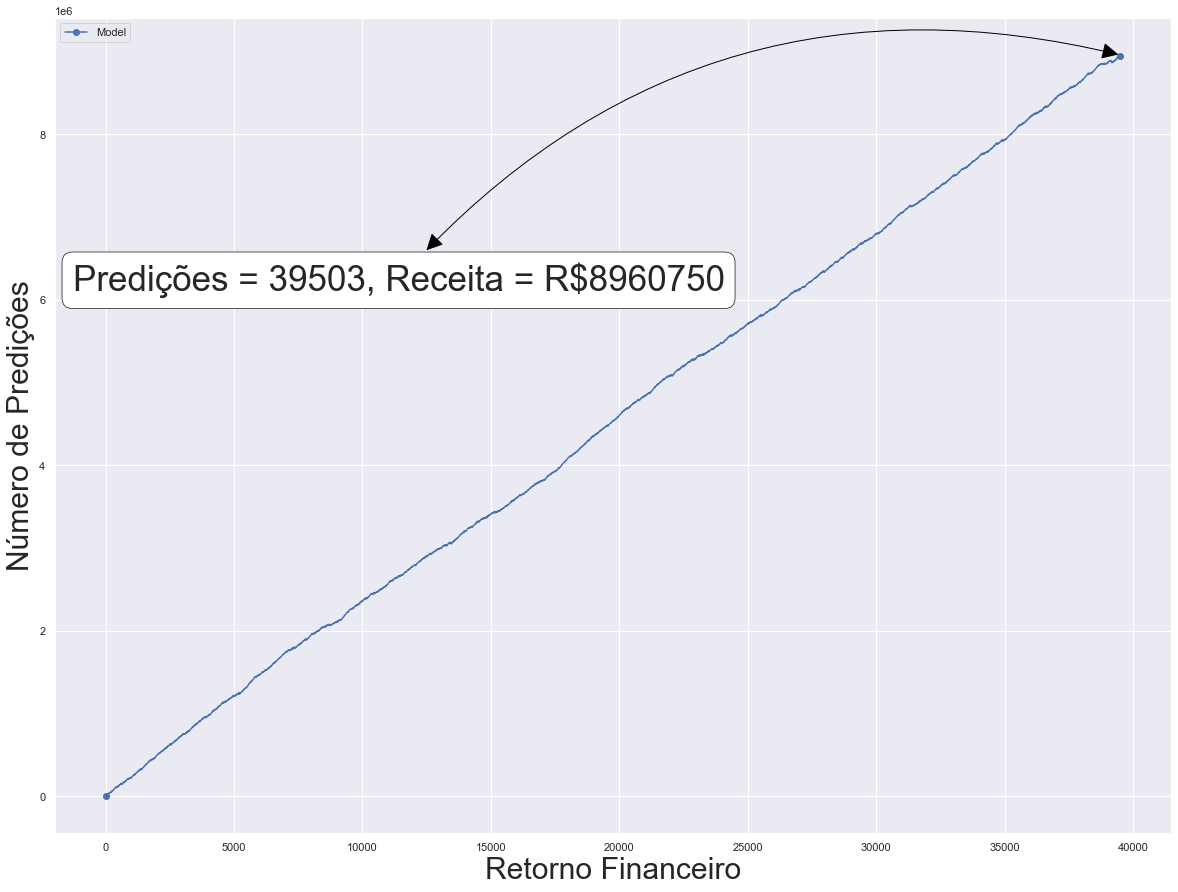

In [153]:
# Create Variables
xx = df9['numero'].to_numpy()
yy = y=df9['acumulado_modelo'].to_numpy()
markers_on = 38487

# Change Graph Size
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['font.size'] = 35

#Create Fig
fig, ax = plt.subplots()
ax.plot(xx, yy, label='Model', marker='o', markevery=39502)

# Annotate Max Profit
xytext1 = (0.6,0.7)
xmax = df9['numero'].max()
ymax = df9['acumulado_modelo'].max()
text= "Predições = {:.0f}, Receita = R${:.0f}".format(xmax, ymax )
ax=plt.gca()
bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="<|-|>",connectionstyle='arc3,rad=-0.3', color='black')
kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
ax.annotate(text, xy=(xmax, ymax), xytext=xytext1, **kw)
plt.legend(loc='upper left')
plt.xlabel('Retorno Financeiro', fontsize=30)
plt.ylabel('Número de Predições', fontsize=30)
plt.show()

## 9.2 Machine Learning Performance

### 9.2.1 ROC Curve

In [154]:
# Model Predict Proba
yhat_xgb_proba = xgb_model_tunned_error.predict_proba( X_validation )

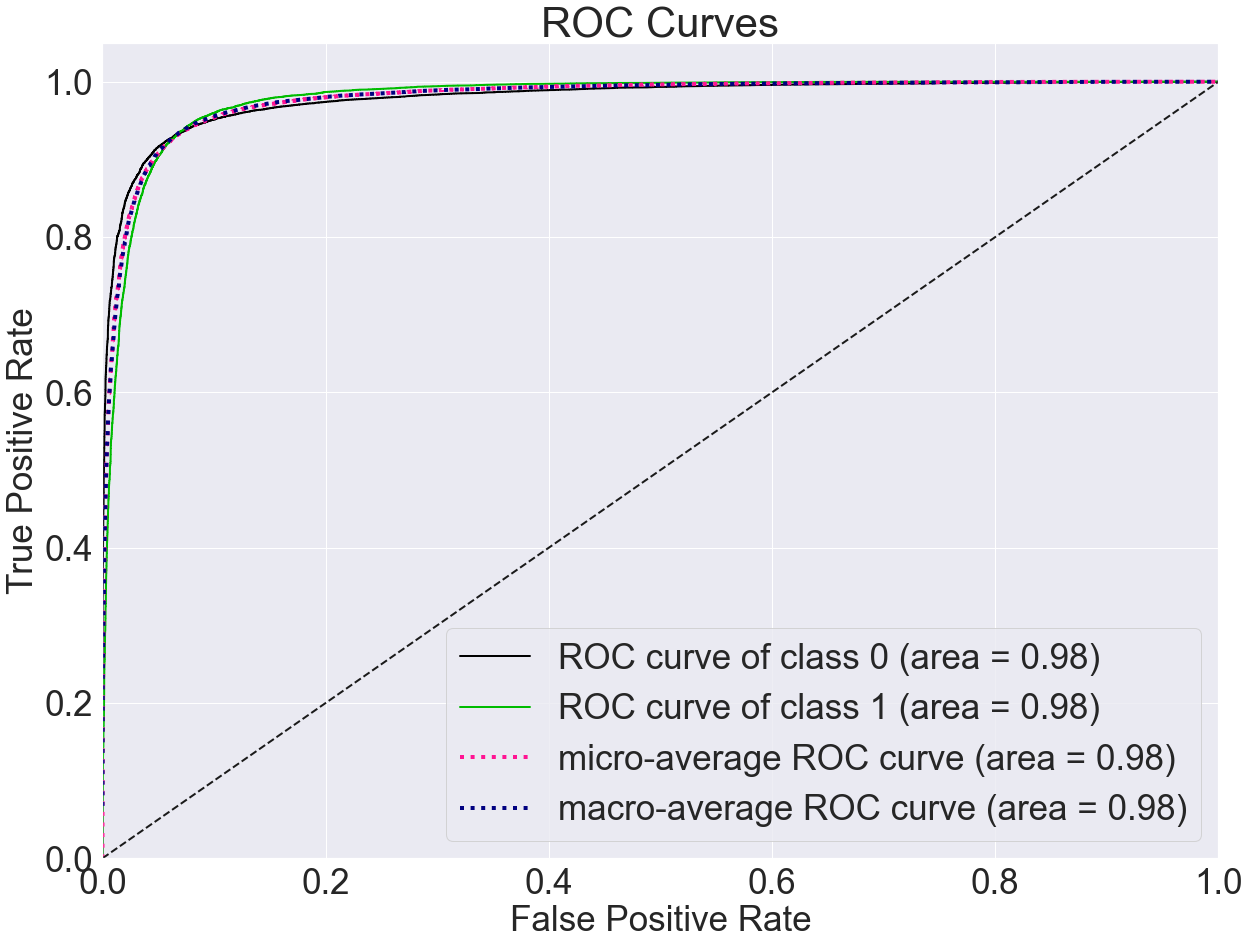

In [155]:
# Plot ROC Curve
# plt.rcParams['figure.figsize'] = [10, 7]
skplt.metrics.plot_roc(y_validation, yhat_xgb_proba)
plt.show()

### 9.2.2 Confusion Matrix

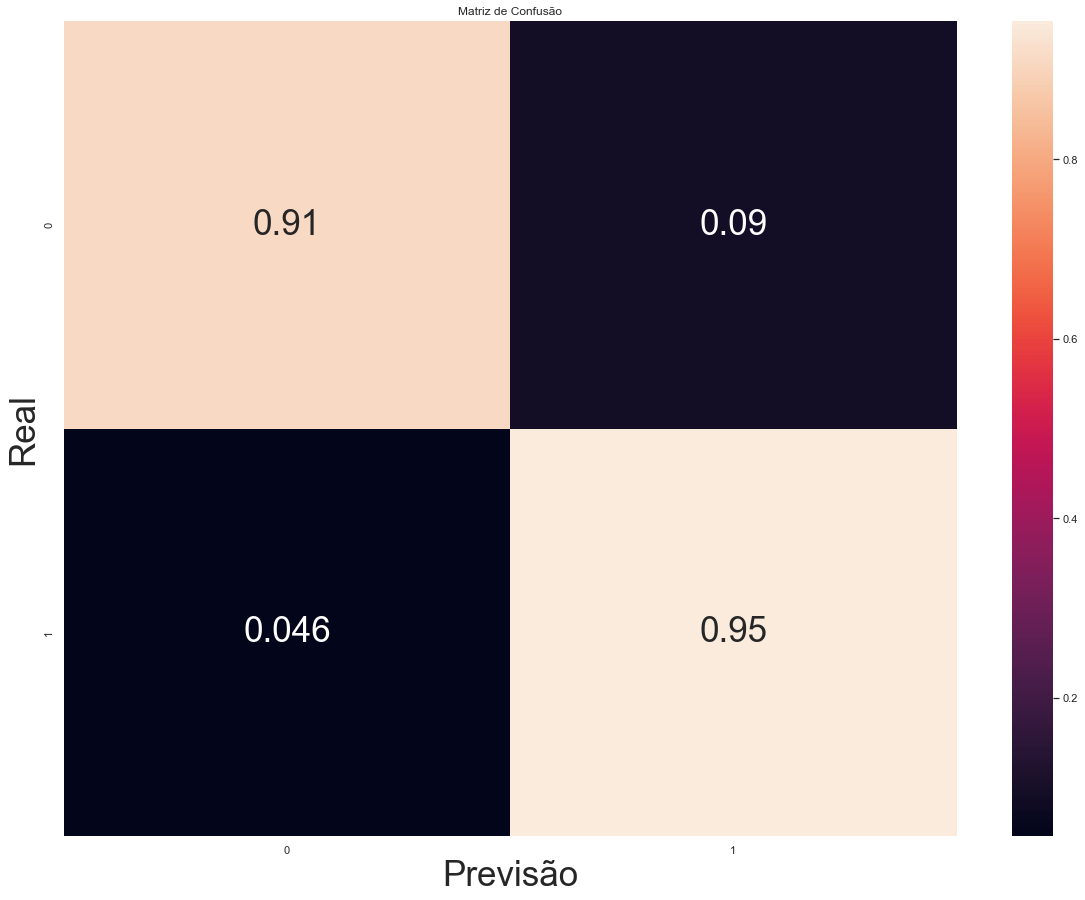

In [156]:
fig, ax = plt.subplots()
sns.heatmap(m.confusion_matrix(y_validation, yhat_xgb_tunned_error, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1 Credit Class

In [ ]:
import pickle
import numpy as np

class Credit( object ):
    def __init__( self ):
        self.home_path = ''
        self.idade_standard = pickle.load( open( self.home_path + 'parameter/idade_standard.pkl', 'rb' ) )
        self.salario_por_dependentes_min_max = pickle.load( open( self.home_path + 
        'parameter/salario_por_dependentes_min_max.pkl', 'rb' ) )
        self.soma_passou_min_max = pickle.load( open( self.home_path + 'parameter/soma_passou_min_max.pkl', 'rb' ) )
        self.util_linhas_inseguras_robust = pickle.load( open( self.home_path + 'parameter/util_linhas_inseguras_robust.pkl', 'rb' ) )
        self.debito_x_salario_robust = pickle.load( open( self.home_path + 'parameter/debito_x_salario_robust.pkl', 'rb' ) )
        self.idade_x_salario_robust = pickle.load( open( self.home_path + 'parameter/idade_x_salario_robust.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        ### Replacing NA
        df1 = df1.replace( 'N/A', np.NaN )

        ### 1.5.1 Salário Mensal
        df1['salario_mensal'].fillna( df1.loc[df1['salario_mensal'] < 300000, 'salario_mensal'].mean(), inplace=True )

        ### 1.5.2 Número de Dependentes
        df1['numero_de_dependentes'].fillna( df1['numero_de_dependentes'].median(), inplace=True )

        ### 1.5.3 Idade
        df1['idade'] = df1['idade'].replace( 0, round( df1['idade'].mean() ) )

        ## 1.6 Change Types
        df1['numero_de_dependentes'] = df1['numero_de_dependentes'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2 ):
        # Salário por denpendentes
        df2['salario_por_dependentes'] = df2[['salario_mensal', 'numero_de_dependentes']].apply( lambda x: x['salario_mensal'] 
        if x['numero_de_dependentes'] == 0 else x['salario_mensal'] / x['numero_de_dependentes'], axis=1 )

        # Salário por número de empréstimos abertos
        df2['salario_por_emprestimos'] = df2[['salario_mensal', 'numero_linhas_crdto_aberto']].apply( lambda x: 
        x['salario_mensal'] if x['numero_linhas_crdto_aberto'] == 0 else x['salario_mensal'] /
        x['numero_linhas_crdto_aberto'], axis=1 )

        # Soma do número de vezesque passou de 30, 60 e 90 dias
        df2['soma_passou'] = df2['vezes_passou_de_30_59_dias'] + df2['numero_vezes_passou_90_dias'] + df2['numero_de_vezes_que_passou_60_89_dias']

        # Razão débito vezes o salário
        df2['debito_x_salario'] = df2['razao_debito'] * df2['salario_mensal']

        # util linhas inseguras vezes numero de linhas de crédito aberto
        df2['linhas_credito_inseguras'] = df2['util_linhas_inseguras'] * df2['numero_linhas_crdto_aberto']

        # Idade vezes o salário
        df2['idade_x_salario'] = df2['idade'] * df2['salario_mensal']
        
        return df2
    
    def data_filtering( self, df3 ):
        ## 3.1 Filtering Rows
        # Removing outliers
        df3 = df3.loc[ df3['salario_mensal'] < 300000, : ]
        df3 = df3.loc[ df3['vezes_passou_de_30_59_dias'] < 50, : ]

        ## 3.2 Filtering Cols

        # High Correlation Variables
        df3 = df3.drop( columns=['vezes_passou_de_30_59_dias', 'numero_vezes_passou_90_dias',
                                 'numero_de_vezes_que_passou_60_89_dias', 'linhas_credito_inseguras'] )
        
        return df3
    
    def data_preparation( self, df5 ):
        
        # ======================== StandardScaler ========================

        # Idade
        df5['idade'] = self.idade_standard.fit_transform( df5[['idade']].values )

        # ======================== MinMaxScaler ========================

        # Salario por Dependentes
        df5['salario_por_dependentes'] = self.salario_por_dependentes_min_max.fit_transform(
        df5[['salario_por_dependentes']].values )

        # Soma Passou
        df5['soma_passou'] = self.soma_passou_min_max.fit_transform( df5[['soma_passou']].values )
        
        # ======================== RobustScaler ========================
        
        # Util Linhas Inseguras
        df5['util_linhas_inseguras'] = self.util_linhas_inseguras_robust.fit_transform( df5[['util_linhas_inseguras']].values)

        # Debito x Salario
        df5['debito_x_salario'] = self.debito_x_salario_robust.fit_transform( df5[['debito_x_salario']].values )

        # Idade x Salario
        df5['idade_x_salario'] = self.idade_x_salario_robust.fit_transform( df5[['idade_x_salario']].values )
        
        cols_selected = [ 'util_linhas_inseguras','idade','salario_por_dependentes',
                          'salario_por_emprestimos','soma_passou','debito_x_salario','idade_x_salario' ]
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # Prediction
        pred = model.predict( test_data )
        
        # Join Pred into Original Data
        original_data['inadimplente'] = pred
        
        return original_data.to_json( orient='records' )

## 10.2 API Handler

In [ ]:
import os
import pickle
import pandas as pd
from flask               import Flask, request, Response
from credit.credit_class import Credit
from xgboost             import XGBClassifier

# Load Model
model = pickle.load( open( 'model/model_credit.pkl', 'rb' ) )

# Initialize API
app = Flask( __name__ )

@app.route( '/credit/predict', methods=['POST'] )

def credit_predict():
    test_json = request.get_json()
    
    if test_json: # There is data
        if isinstance( test_json, dict ): # Unique json
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # Multiple json
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Credit Class
        pipeline = Credit()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw.copy() )
        
        # Feature Engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Predict
        df_response = pipeline.get_prediction( model, test_raw, df3 )
            
        return df_response
        
    else: # there is no data
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    porti = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=porti, debug=True )

## 10.3 API Tester

### 10.3.1 Local Tester

In [ ]:
# Loading Dataset
df_test = pd.read_csv( '../data/teste.csv', low_memory=True )

In [ ]:
# Choose Rows for Prediction
df_test = df_test.iloc[ 0:10, : ]

In [ ]:
df_test

In [ ]:
# Convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
url = 'http://0.0.0.0:5000/credit/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )

print( f'Status Code: { r.status_code }' )

In [ ]:
df_api = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
df_api

### 10.3.2 Remote Tester

In [178]:
# Loading Dataset
df_test = pd.read_csv( '../data/teste.csv', low_memory=True )

In [170]:
# Choose Rows for Prediction
df_test = df_test.iloc[ 0:10, : ]

In [171]:
df_test

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0
5,0.323985,42,0,0.352151,10415.0,8,0,2,0,2.0
6,0.007300,63,0,0.002289,4368.0,2,0,0,0,0.0
7,0.000000,76,1,0.261611,1700.0,4,0,0,0,0.0
8,0.062280,55,0,0.406667,15658.0,14,1,3,0,0.0
9,0.479899,41,1,0.209903,8441.0,6,0,3,0,0.0


In [172]:
# Convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [173]:
# API Call
url = 'https://credit-prediction.onrender.com/credit/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )

print( f'Status Code: { r.status_code }' )

Status Code: 200


In [174]:
df_api = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [175]:
df_api

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0
5,0.323985,42,0,0.352151,10415.0,8,0,2,0,2.0,0
6,0.007300,63,0,0.002289,4368.0,2,0,0,0,0.0,0
7,0.000000,76,1,0.261611,1700.0,4,0,0,0,0.0,0
8,0.062280,55,0,0.406667,15658.0,14,1,3,0,0.0,0
9,0.479899,41,1,0.209903,8441.0,6,0,3,0,0.0,1


### 10.3.3 Predict Test Dataset

In [164]:
# Loading Dataset
df_test = pd.read_csv( '../data/teste.csv', low_memory=True )

In [165]:
# Convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [166]:
# API Call
url = 'https://credit-prediction.onrender.com/credit/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )

print( f'Status Code: { r.status_code }' )

Status Code: 200


In [167]:
df_api = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [168]:
df_api.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


In [ ]:
# # Save dataset into disk
# df_api.to_csv( '../data/test_predicted.csv', sep=',', index=False )